In [1]:
!pip install transformers[torch]==4.19.2 shap -qU

In [2]:
import numpy as np
import shap
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available: ",device)
seed = 42
np.random.seed(seed)

Device available:  cuda


In [3]:
# Trained Model
distilbert_model_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/model/distilbert_unprocessed_v1.pth'
# Input Data
data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/samples_with_probs_135.csv'
example_data_path = '/content/drive/MyDrive/NLP_LSS/distinctiveness_indicator/distilbert/data/bb_spectrum_of_example_marks.xlsx'
# DistilBERT Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
# Temperature
TEMP = 0.75

model = torch.load(distilbert_model_path)
class_names = ['not distinct','distinct']

In [4]:
# Function to generate batches and reshape
def batching(np_array, max_idx, batch_size):
    np_array = np_array[:max_idx]
    np_array = np_array.reshape(-1, batch_size)
    batched_list = np_array.tolist()
    return batched_list

In [5]:
# Temperature Scaling
def T_scaling(logits, args):
    temperature = args.get('temperature', None)
    return torch.div(logits, temperature)

In [6]:
# Predictor function for SHAP - takes list of strings as input
def predictor_shap(text_list):
    X = batching(np.array(text_list), max_idx=len(text_list), batch_size=1)
    pred_prob = []
    pred_logits = []
    model.eval()
    with torch.no_grad():
        for text in tqdm(X, total=len(X)):
            model_inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
            output = model(**model_inputs)
            logits = output[0]
            logits = T_scaling(logits, {'temperature':TEMP})
            probs = torch.sigmoid(logits)
            pred_prob.extend(probs[:,1].tolist())
    return pred_prob

In [7]:
def preprocess(input_text):
  text = input_text.replace("[SEP]", "\n")
  text = text.replace("[CLS]", "")
  return text

In [8]:
## Function to get word level scores from SHAP

def get_word_level_scores(shap_values, text, idx=0):
  # Strip text
  text = text.strip()
  # Split text
  text_split = text.split()
  # Will have word level scores
  word_level_scores = []
  # Subwords and corresponding scores from SHAP
  subwords = shap_values.data[idx]
  subword_scores = shap_values.values[idx]
  nsubwords = shap_values.data[idx].shape[0]
  # Iterator for word in text
  word_counter = 0
  # Initialize current subword, number of subwords needed to make a word and word score
  curr_subword = ''
  nsub = 0
  word_score = 0
  for i in range(nsubwords):
    # Don't consider empty string
    if subwords[i]==' ':
      continue
    # If subword matches current text word, append to list
    if curr_subword.strip() == text_split[word_counter].strip():
      word_level_scores.append((text_split[word_counter], word_score/nsub))
      word_counter += 1
      nsub = 0
      curr_subword = ''
      word_score = 0
    # Concatenate subwords
    curr_subword += subwords[i]
    word_score += subword_scores[i]
    nsub += 1

  assert(len(word_level_scores)==len(text_split))
  return word_level_scores

In [9]:
from IPython.display import HTML

def highlight_words(wordlevel_scores):
  words = [x[0] for x in wordlevel_scores]
  scores = [x[1] for x in wordlevel_scores]
  maxscore = max(scores)
  minscore = min(scores)
  normscores = [(x-minscore)/(maxscore-minscore) for x in scores]

  # Create HTML content with words highlighted based on numeric values
  html_content = "<p>"
  for word, value in zip(words, normscores):
      color = f"rgba(0, {int(255 * value)}, 0, 0.5)"
      html_content += f'<span style="background-color: {color};">{word} </span>'
  html_content += "</p>"

  # Explanation for colors and colormap legend
  explanation = "<p>Explanation for colors:</p>"
  explanation += "<ul>"
  explanation += "<li>Words with high numeric values have a color closer to green.</li>"
  explanation += "</ul>"

  # Display the HTML content, explanation, and colormap legend in the notebook
  display(HTML(explanation))
  display(HTML(html_content))


In [10]:
import matplotlib.patches as mpatches
import seaborn as sns
def plot_bar(wordlevel_scores, topk=3):
  sns.set_theme()
  sorted_scores = sorted(wordlevel_scores, key=lambda tup: tup[1], reverse=True)

  # Get scores
  scores = [x[1] for x in sorted_scores]

  # Select top-k and bottom-k words
  topk_scores = scores[:topk]
  bottomk_scores = scores[-topk:]
  all_scores = topk_scores + bottomk_scores

  # Top-k and Bottom-k words
  topk_words = [x[0] for x in sorted_scores[:topk]]
  bottomk_words = [x[0] for x in sorted_scores[-topk:]]
  all_words = topk_words + bottomk_words
  groups = ['Bottom{k}'.format(k=topk)]*topk + ['Top{k}'.format(k=topk)]*topk

  # Create a dictionary to map unique groups to colors
  unique_groups = sorted(set(groups))
  color_map = {group: plt.cm.viridis(i / len(unique_groups)) for i, group in enumerate(unique_groups)}

  # Map each group to a color
  colors = [color_map[group] for group in groups]

  # Create a horizontal bar plot
  fig, ax = plt.subplots()
  bars = ax.barh(list(reversed(all_words)), list(reversed(all_scores)), color=colors)

  # Add labels and title
  ax.set_xlabel('Attribution to distinctiveness')
  ax.set_ylabel('Words')
  ax.set_title('Word-Level SHAP attributions')

  # Add a color legend
  legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[group], label=group) for group in unique_groups]
  ax.legend(handles=legend_handles, labels=unique_groups, loc='lower right')

  # Show the plot
  plt.show()



  # y_pos = np.arange(len(all_words))
  # # Bar plot - TopK
  # plt.barh(y_pos, list(reversed(all_scores)), align='center')
  # plt.yticks(y_pos, list(reversed(all_words)))
  # plt.xlabel('Top {k} Word Level Attribution'.format(k=topk))
  # plt.axhline(y = 2.5, color = 'grey', linestyle = '--')
  # plt.show()
  # print("\n\n\n")


### Load Data

In [11]:
def get_decile(x):
  return int(10 * x) + 1

In [12]:
df = pd.read_csv(data_path)
df = df.sort_values(by=['pred_probs'], ascending=True)
df['deciles'] = df['pred_probs'].apply(lambda x: get_decile(x))
df.head()

serial_no                            mark_unprocessed  \
3   88682238        NATIONAL PEST MANAGEMENT ASSOCIATION   
1   88711637                       USA BACKGROUND CHECKS   
4   88523711  INTERNATIONAL PRODUCTION & PROCESSING EXPO   
0   88284833                  SECURE TECHNOLOGY ALLIANCE   
2   88565473                   USA SURFING CHAMPIONSHIPS   

                               statement_unprocessed  distinct_ind  \
3  "ASSOCIATION" Association services, namely, pr...             0   
1  "BACKGROUND CHECKS" Background screenings and ...             0   
4  "PRODUCTION & PROCESSING EXPO" Conducting trad...             0   
0  "ALLIANCE" Association services, namely, raisi...             0   
2  "SURFING CHAMPIONSHIPS" Arranging, organizing,...             0   

   pred_probs    intervals  deciles  
3      0.0027  (0.0, 0.01]        1  
1      0.0063  (0.0, 0.01]        1  
4      0.0068  (0.0, 0.01]        1  
0      0.0082  (0.0, 0.01]        1  
2      0.0095  (0.0, 0.01]        1

In [14]:
def get_shap_plots(df, decile):
  df_decile = df[df['deciles']==decile].copy()
  df_decile.reset_index(drop=True, inplace=True)
  # Iterate through all the samples
  # Print interval 1
  # Get Shap Scores

  for idx, row in df_decile.iterrows():
    mark = row['mark_unprocessed']
    desc = row['statement_unprocessed']
    prob = row['pred_probs']
    sentence = mark + '. ' + desc
    print(prob)
    shap_explainer = shap.Explainer(predictor_shap, tokenizer, silent=True)
    shap_values = shap_explainer([sentence], silent=True)
    wordlevel_scores = get_word_level_scores(shap_values, sentence)
    highlight_words(wordlevel_scores)
    plot_bar(wordlevel_scores)
    print("\n\n\n")
    print("=========================================================================================================")



0.0027


100%|██████████| 4/4 [00:00<00:00, 169.04it/s]


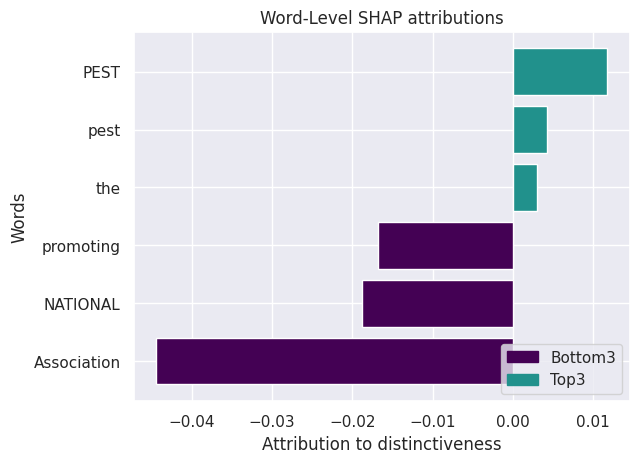





0.0063


100%|██████████| 4/4 [00:00<00:00, 153.48it/s]


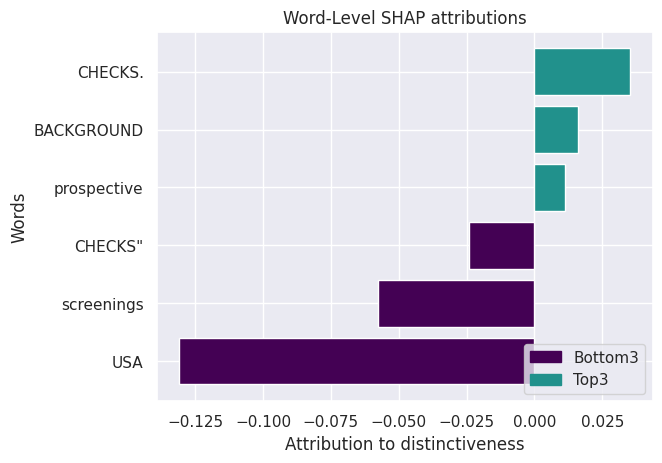





0.0068


100%|██████████| 4/4 [00:00<00:00, 152.31it/s]


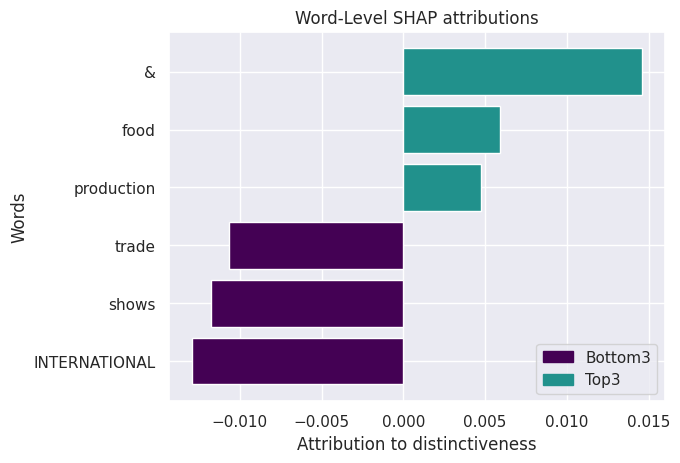





0.0082


100%|██████████| 4/4 [00:00<00:00, 154.09it/s]


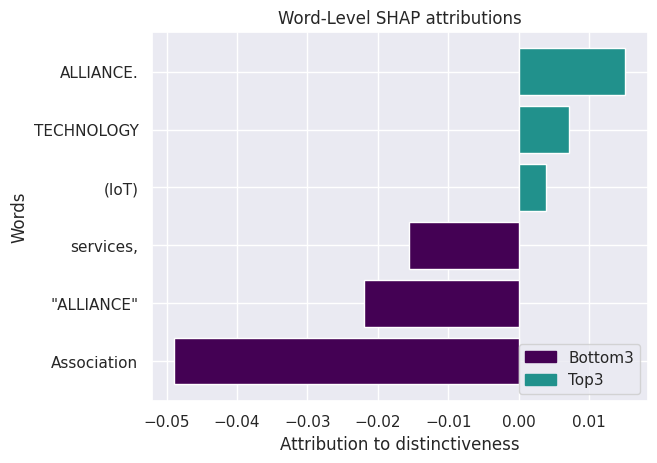





0.0095


100%|██████████| 4/4 [00:00<00:00, 145.77it/s]


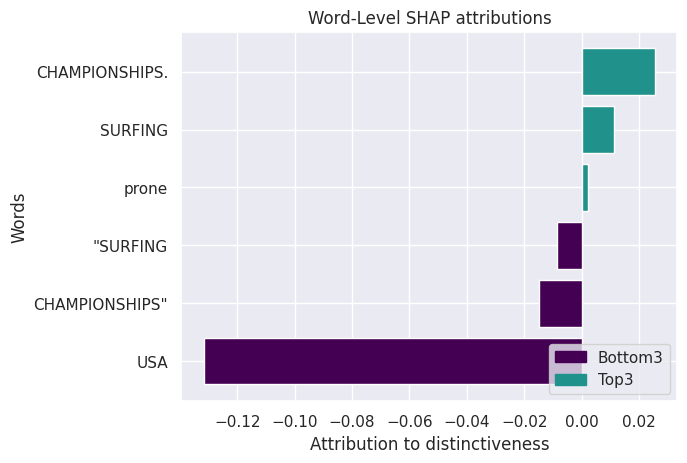





0.0103


100%|██████████| 4/4 [00:00<00:00, 153.35it/s]


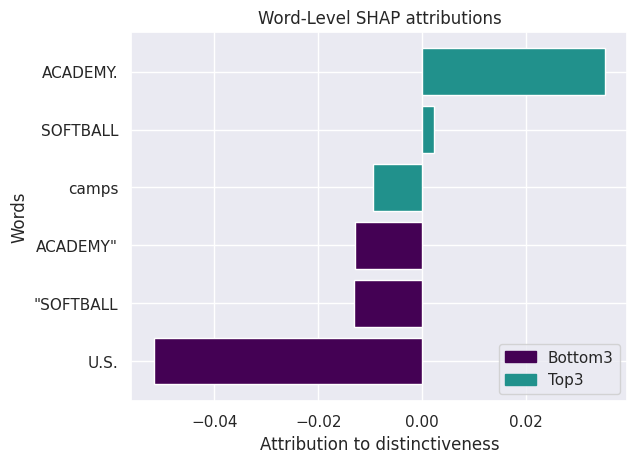





0.0151


100%|██████████| 4/4 [00:00<00:00, 164.64it/s]


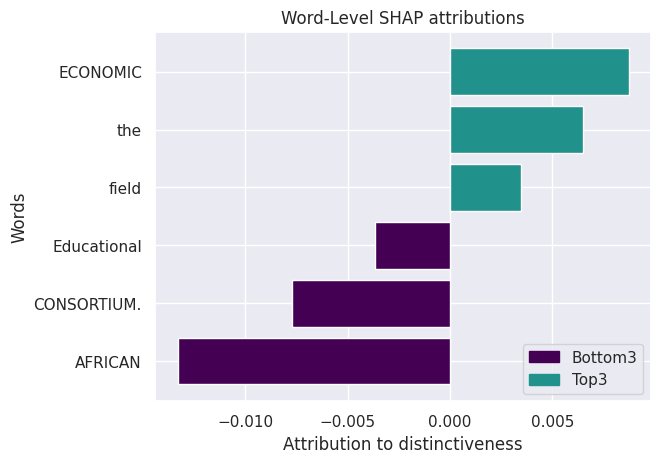





0.0157


100%|██████████| 4/4 [00:00<00:00, 156.56it/s]


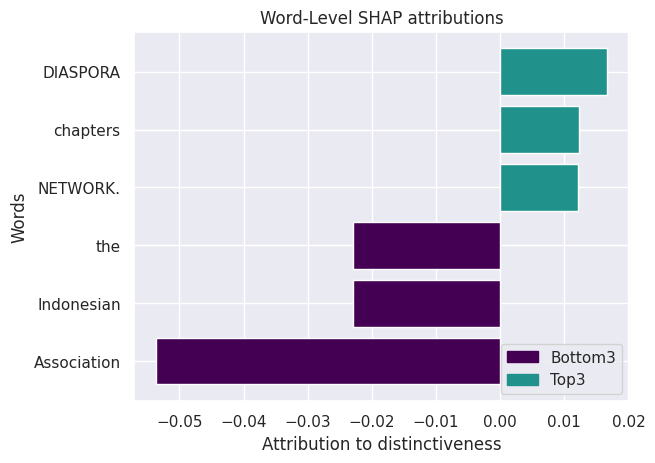





0.016


100%|██████████| 4/4 [00:00<00:00, 161.45it/s]


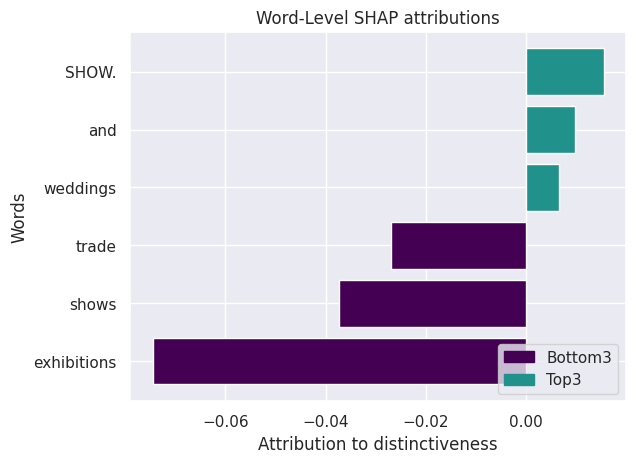





0.0175


100%|██████████| 4/4 [00:00<00:00, 164.72it/s]


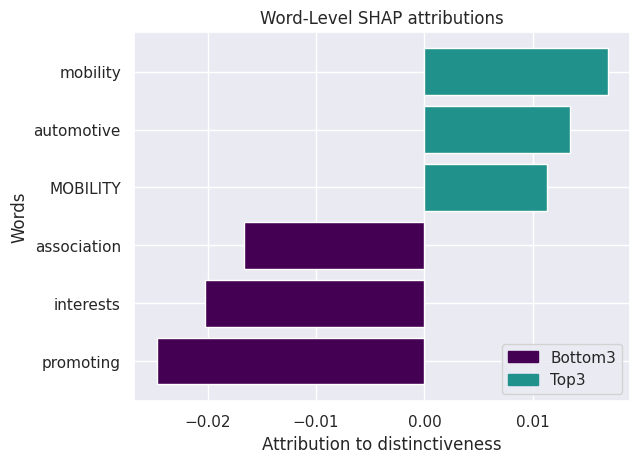





0.0228


100%|██████████| 4/4 [00:00<00:00, 136.73it/s]


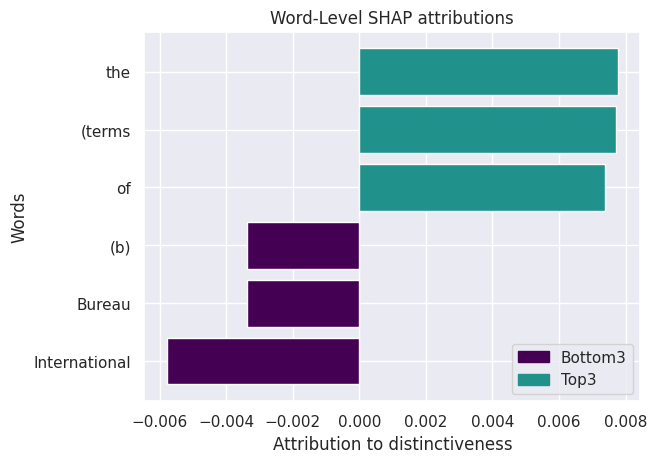





0.0233


100%|██████████| 4/4 [00:00<00:00, 150.71it/s]


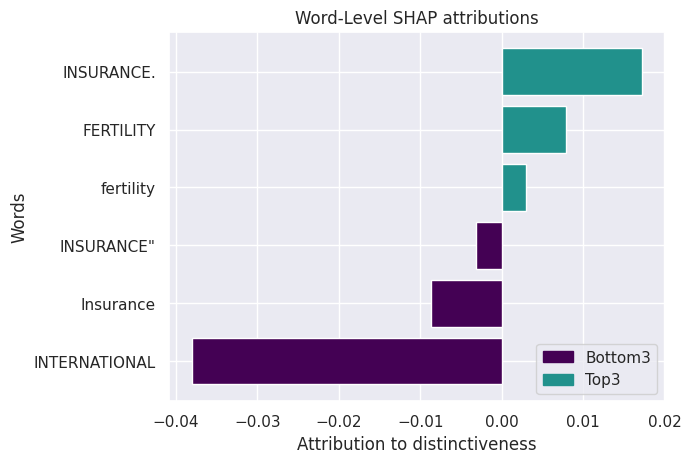





0.0251


100%|██████████| 4/4 [00:00<00:00, 141.32it/s]


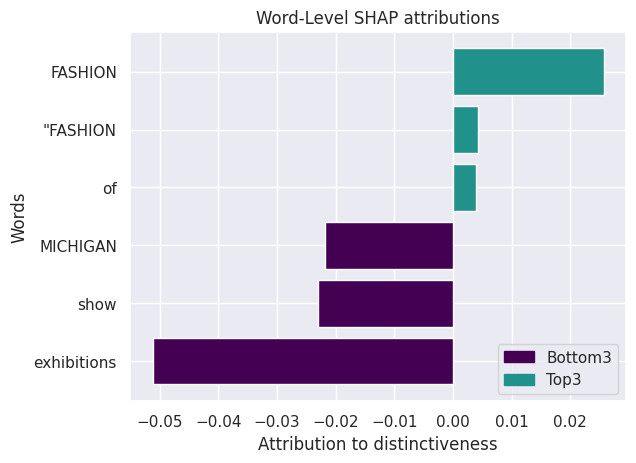





0.0259


100%|██████████| 4/4 [00:00<00:00, 141.13it/s]


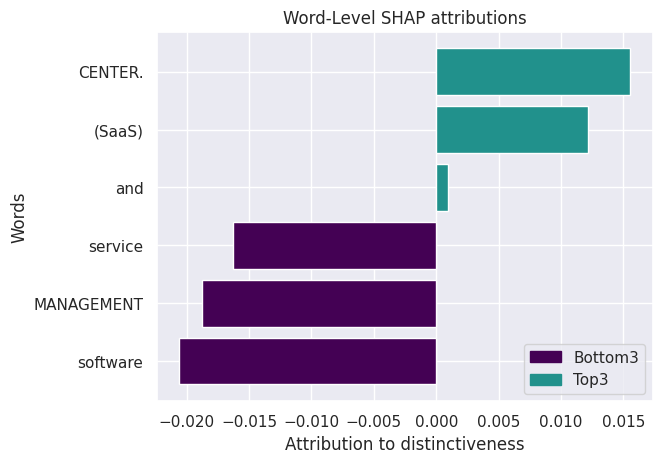





0.0296


100%|██████████| 4/4 [00:00<00:00, 128.23it/s]


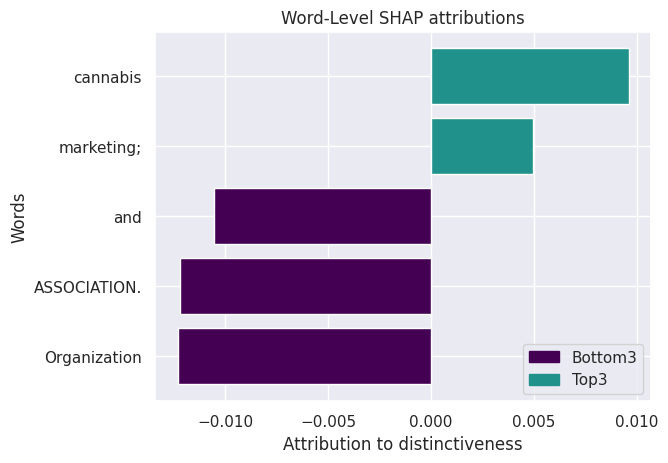





0.032


100%|██████████| 4/4 [00:00<00:00, 163.10it/s]


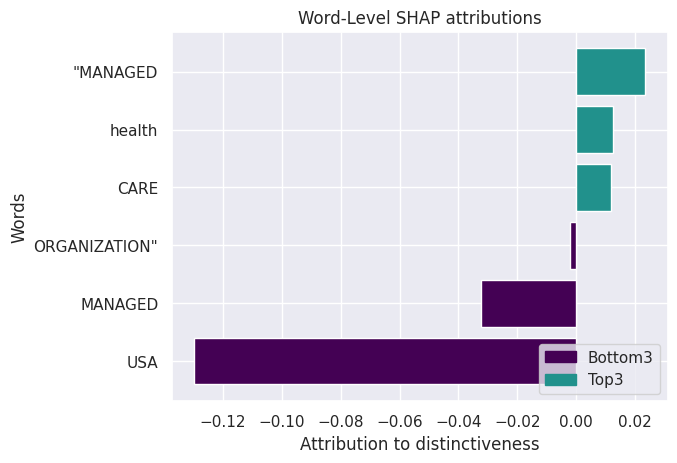





0.0322


100%|██████████| 4/4 [00:00<00:00, 152.66it/s]


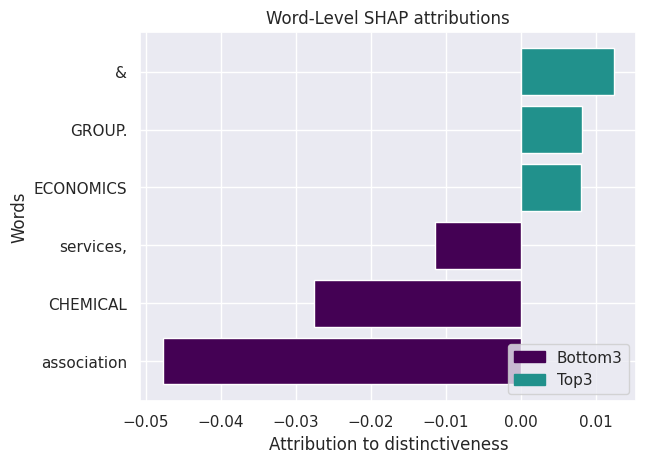





0.0326


100%|██████████| 4/4 [00:00<00:00, 171.07it/s]


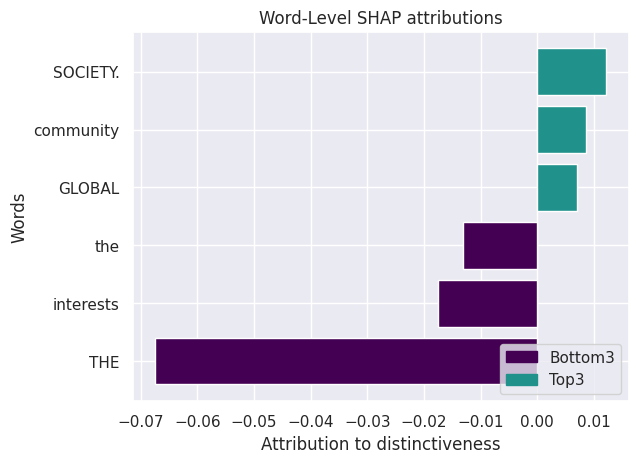





0.0356


100%|██████████| 4/4 [00:00<00:00, 138.25it/s]


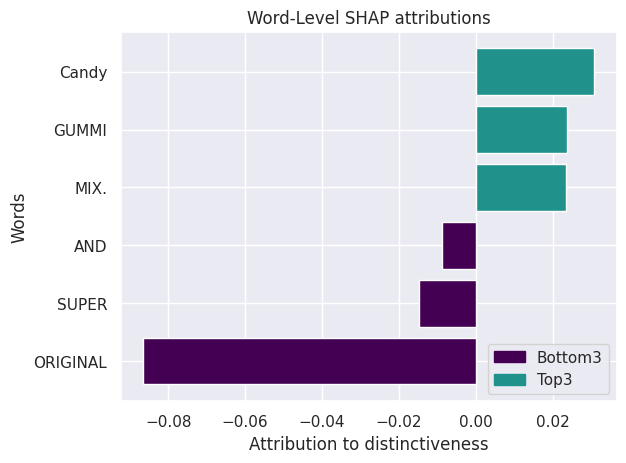





0.0368


100%|██████████| 4/4 [00:00<00:00, 158.27it/s]


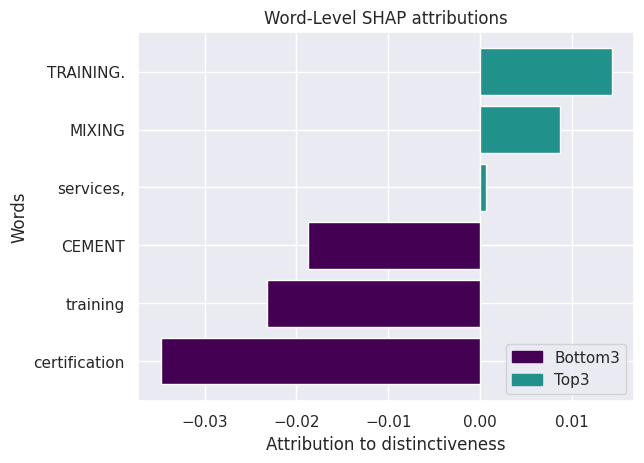





0.0409


100%|██████████| 4/4 [00:00<00:00, 158.65it/s]


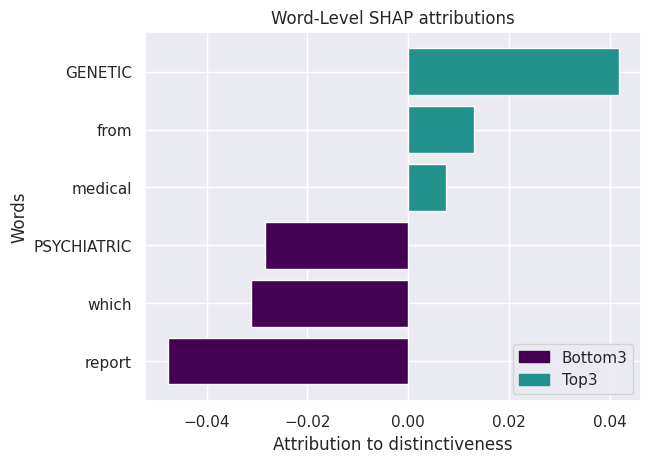





0.041


100%|██████████| 4/4 [00:00<00:00, 137.00it/s]


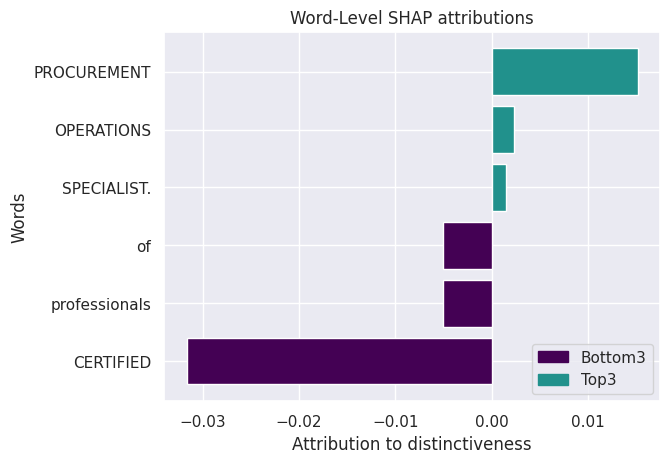





0.044


100%|██████████| 4/4 [00:00<00:00, 158.86it/s]


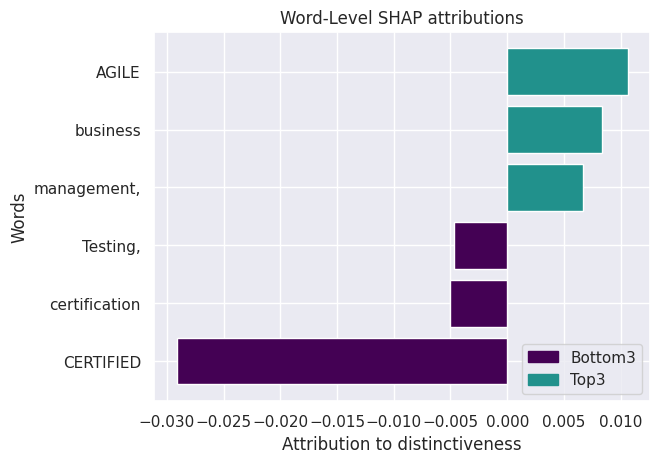





0.0458


100%|██████████| 4/4 [00:00<00:00, 152.08it/s]


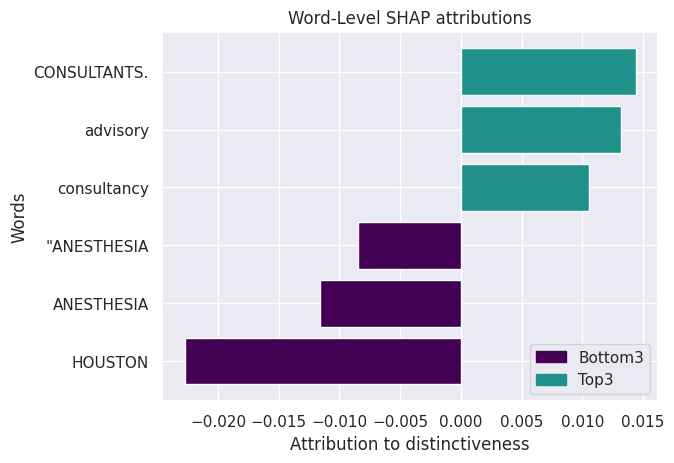





0.0488


100%|██████████| 4/4 [00:00<00:00, 151.76it/s]


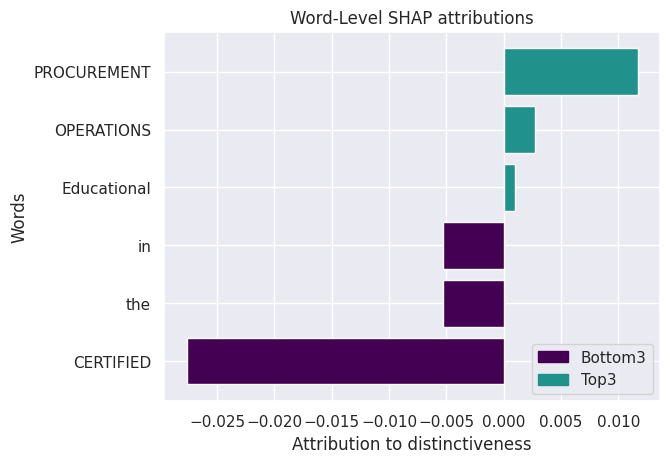





0.0505


100%|██████████| 4/4 [00:00<00:00, 161.01it/s]


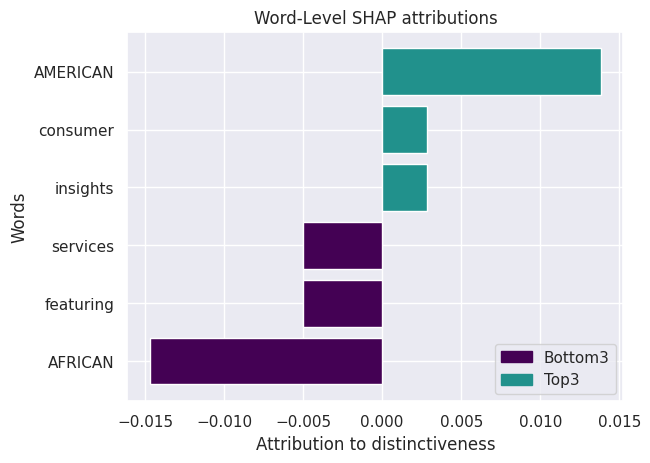





0.0732


100%|██████████| 4/4 [00:00<00:00, 158.28it/s]


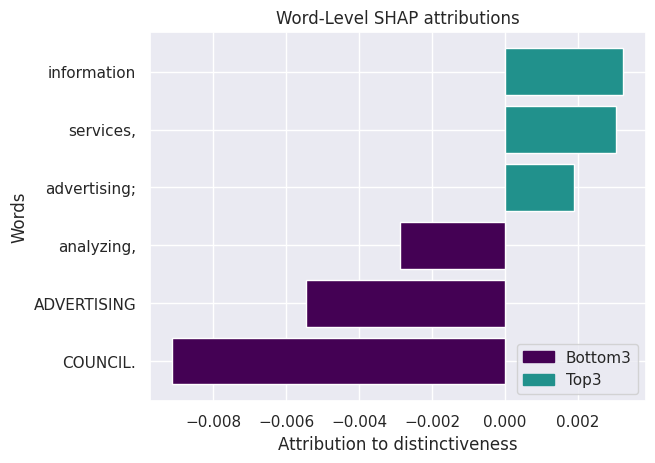





0.0765


100%|██████████| 4/4 [00:00<00:00, 169.38it/s]


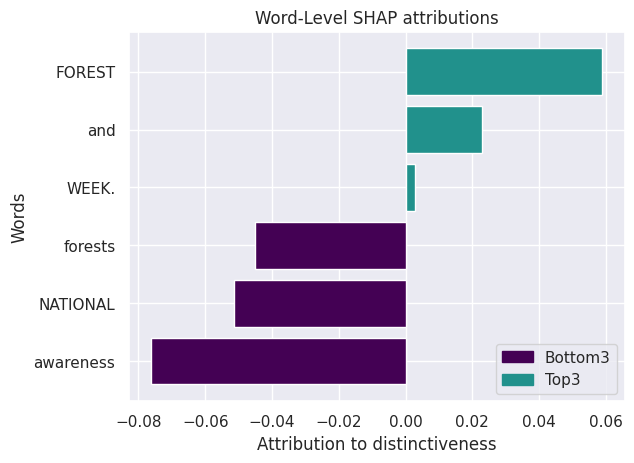





0.0907


100%|██████████| 4/4 [00:00<00:00, 162.09it/s]


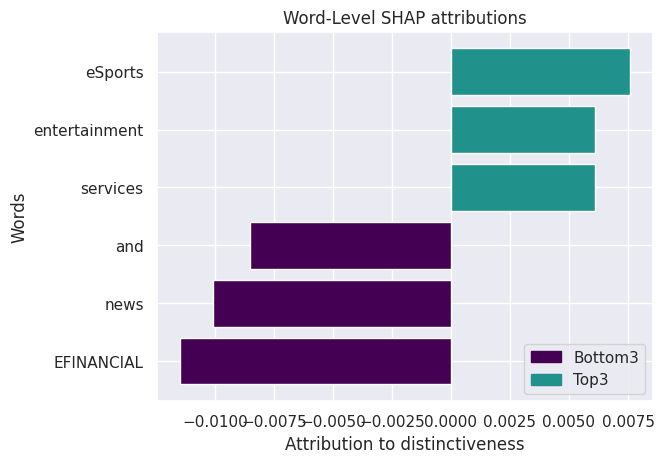





0.0971


100%|██████████| 4/4 [00:00<00:00, 106.91it/s]


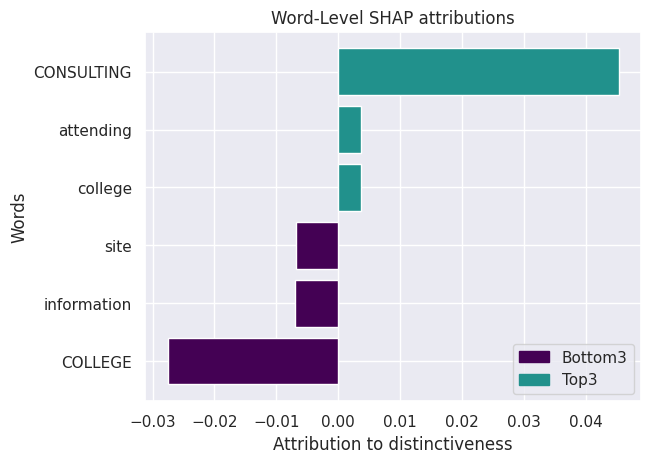

In [15]:
get_shap_plots(df, 1)

0.104


100%|██████████| 4/4 [00:00<00:00, 150.08it/s]


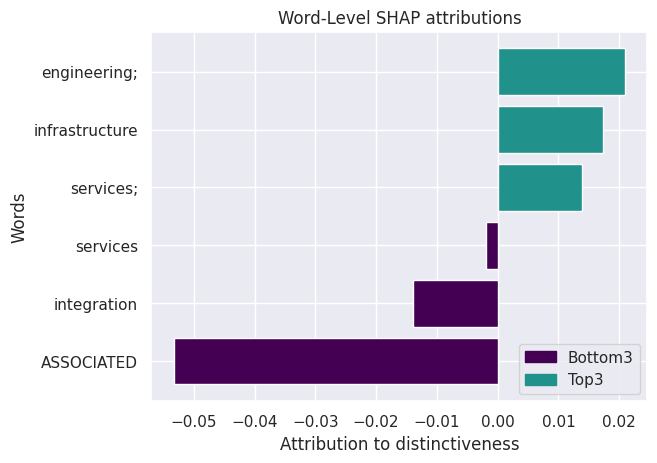





0.1101


100%|██████████| 4/4 [00:00<00:00, 171.64it/s]


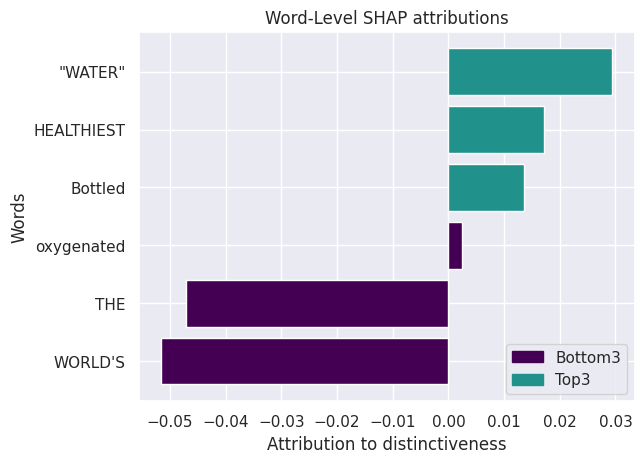





0.1236


100%|██████████| 4/4 [00:00<00:00, 161.54it/s]


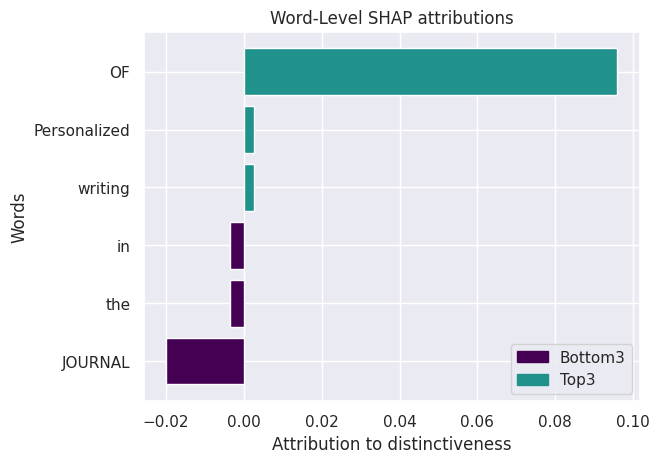

Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors






0.1305


100%|██████████| 4/4 [00:00<00:00, 112.07it/s]


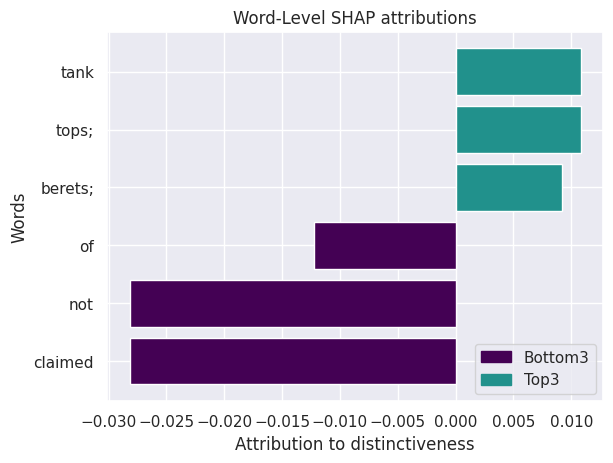





0.1346


100%|██████████| 4/4 [00:00<00:00, 158.77it/s]


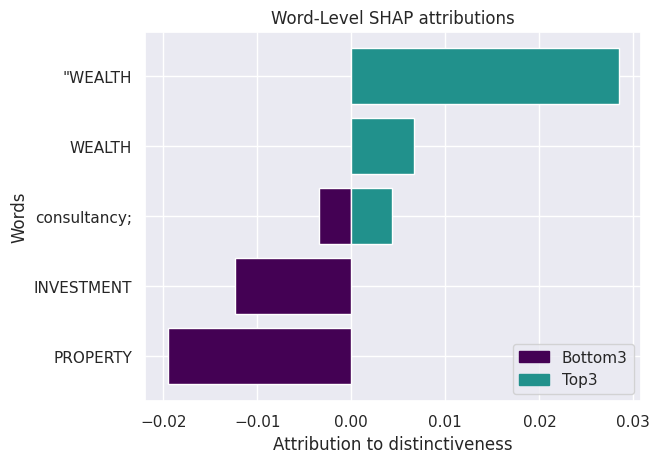





0.1682


100%|██████████| 4/4 [00:00<00:00, 160.06it/s]


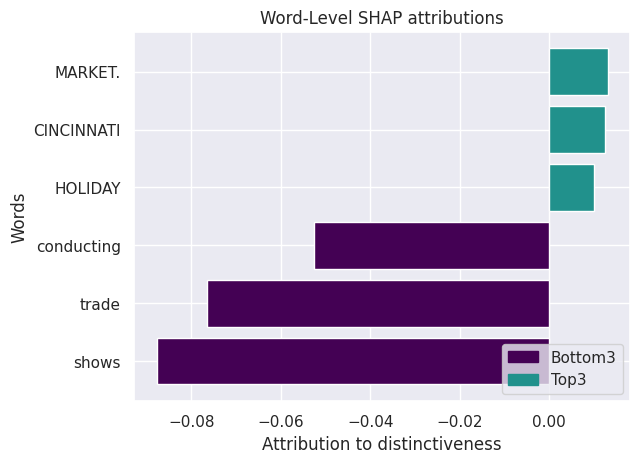





0.1735


100%|██████████| 4/4 [00:00<00:00, 167.34it/s]


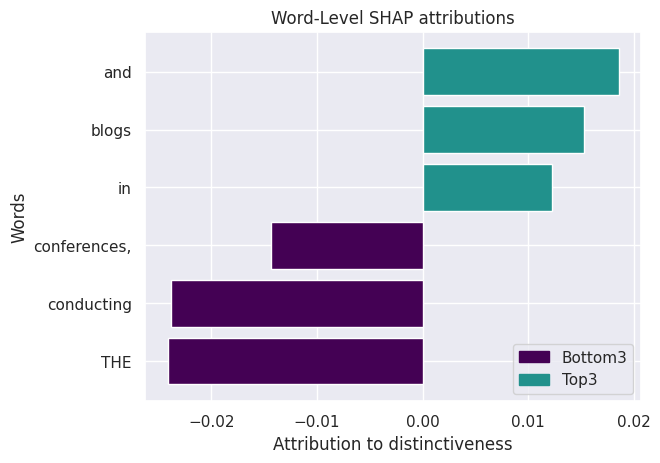





0.1781


100%|██████████| 4/4 [00:00<00:00, 161.05it/s]


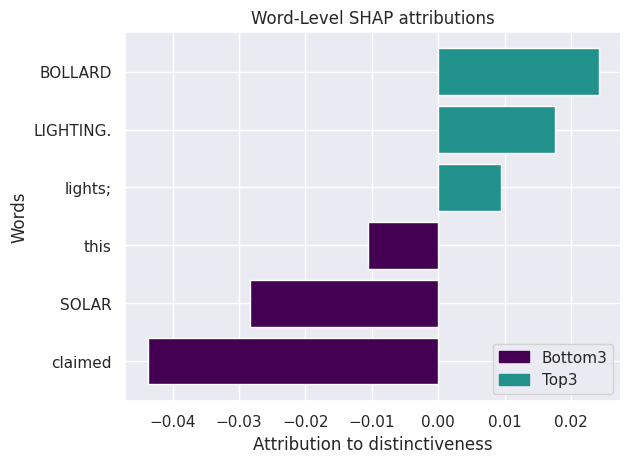





0.1971


100%|██████████| 4/4 [00:00<00:00, 156.65it/s]


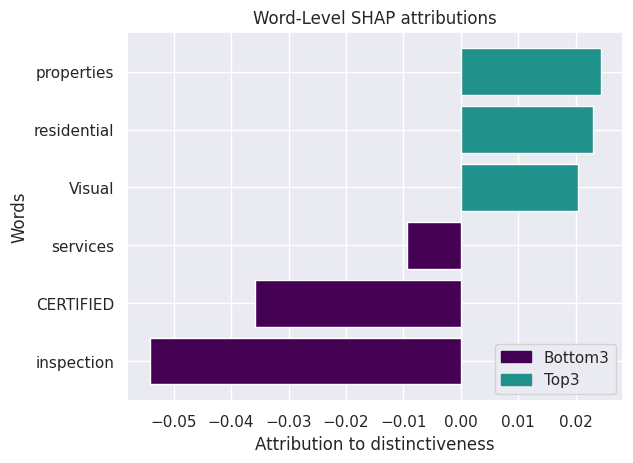





0.1971


100%|██████████| 4/4 [00:00<00:00, 164.86it/s]


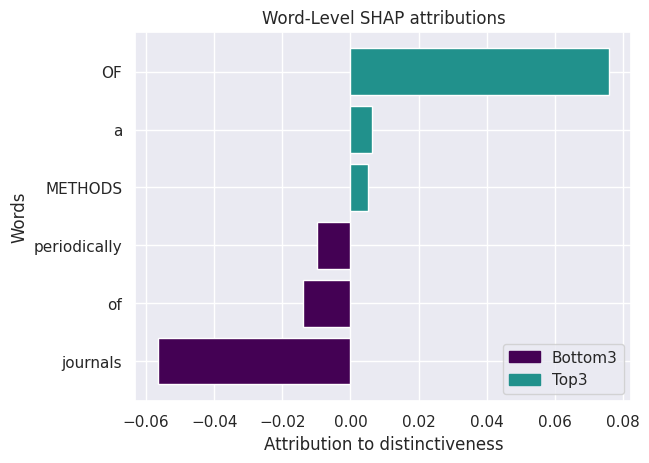

In [16]:
get_shap_plots(df, 2)

0.2095


100%|██████████| 4/4 [00:00<00:00, 170.77it/s]


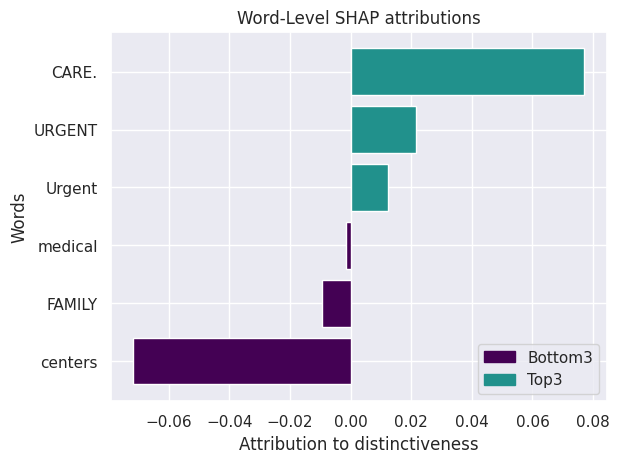





0.2097


100%|██████████| 4/4 [00:00<00:00, 169.98it/s]


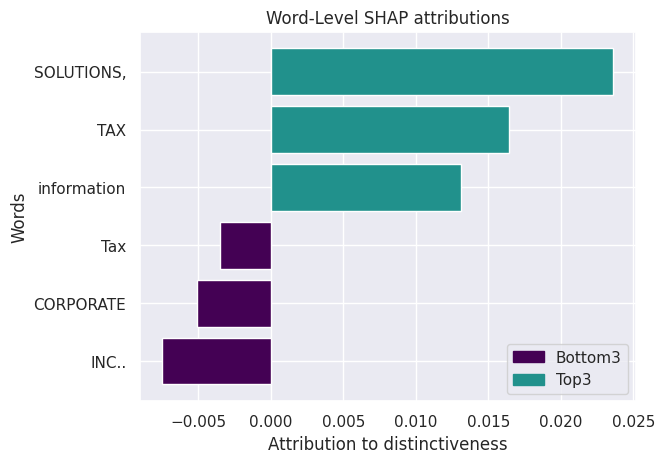





0.211


100%|██████████| 4/4 [00:00<00:00, 167.94it/s]


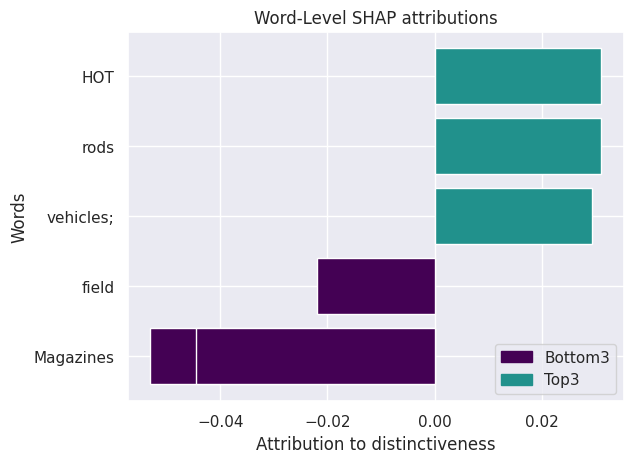





0.2312


100%|██████████| 4/4 [00:00<00:00, 166.90it/s]


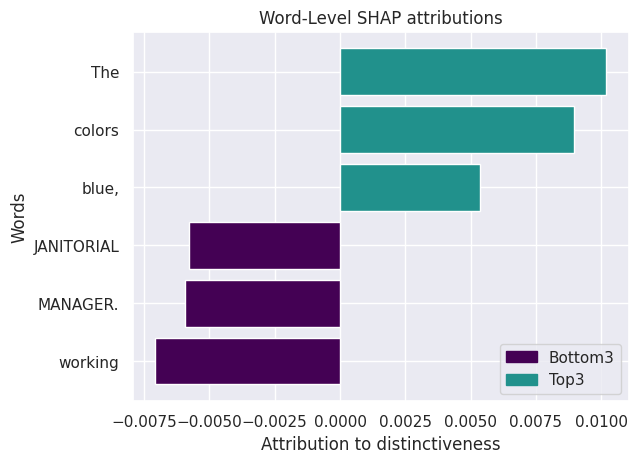





0.2369


100%|██████████| 2/2 [00:00<00:00, 171.44it/s]


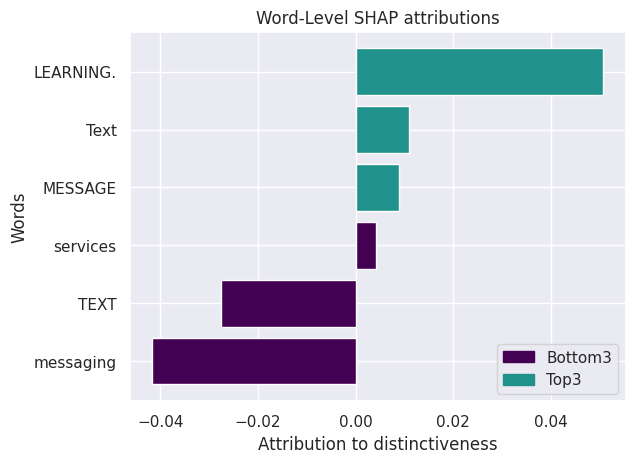





0.2503


100%|██████████| 4/4 [00:00<00:00, 166.93it/s]


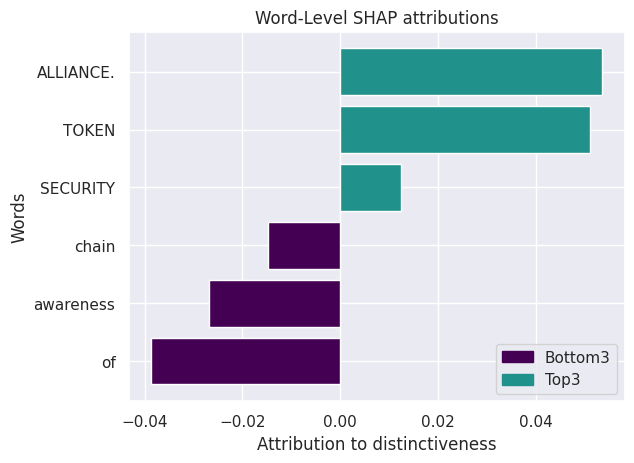





0.2758


100%|██████████| 6/6 [00:00<00:00, 175.08it/s]


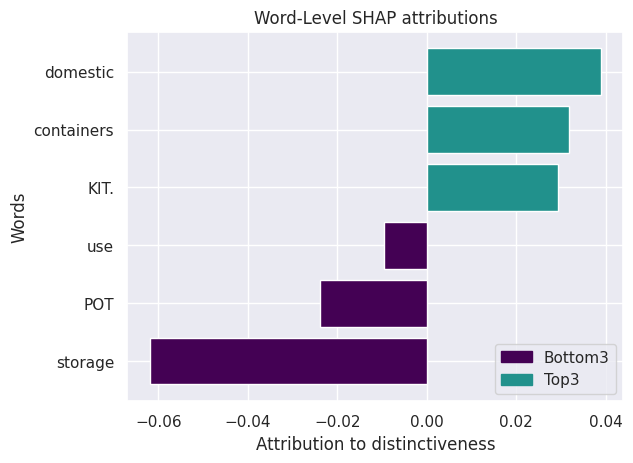





0.2794


100%|██████████| 4/4 [00:00<00:00, 165.94it/s]


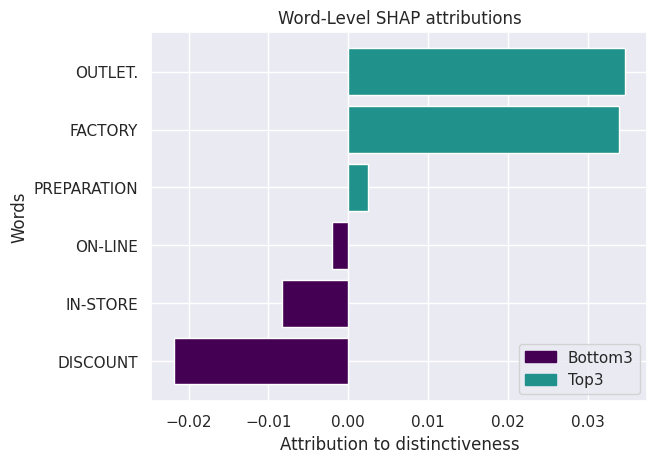





0.2799


100%|██████████| 4/4 [00:00<00:00, 140.51it/s]


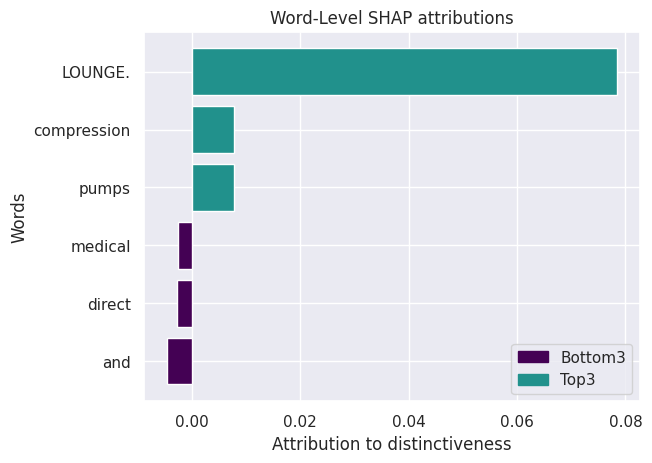





0.2835


100%|██████████| 2/2 [00:00<00:00, 155.64it/s]


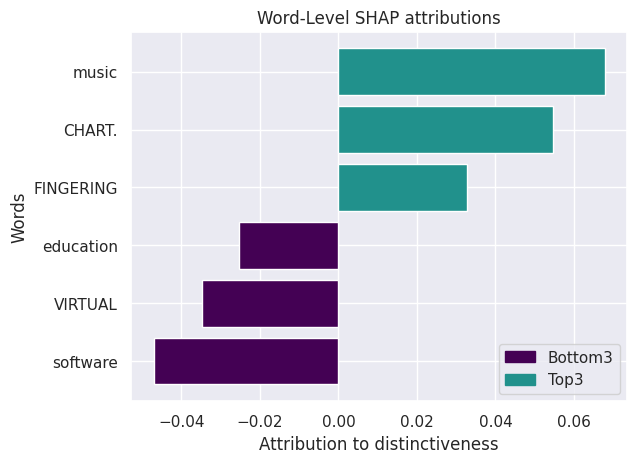

In [17]:
get_shap_plots(df, 3)

0.3015


100%|██████████| 4/4 [00:00<00:00, 165.71it/s]


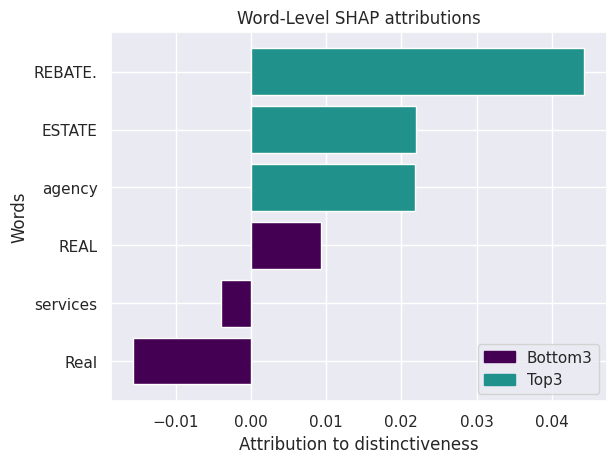





0.3072


100%|██████████| 4/4 [00:00<00:00, 159.49it/s]


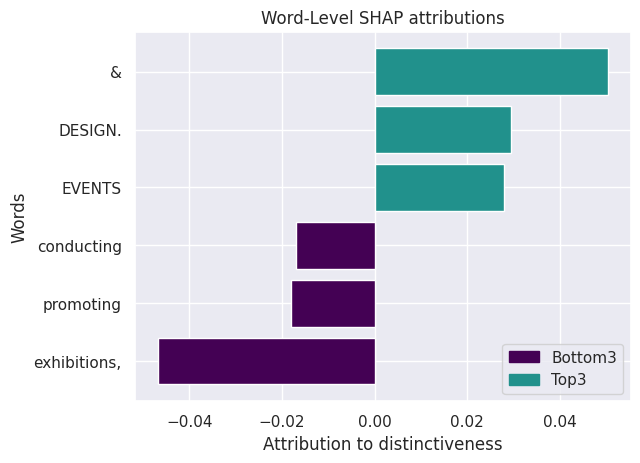





0.3116


100%|██████████| 4/4 [00:00<00:00, 163.26it/s]


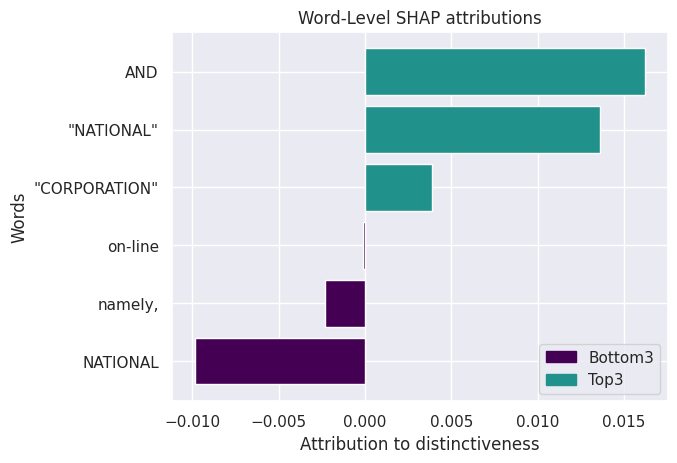





0.3314


100%|██████████| 4/4 [00:00<00:00, 152.07it/s]


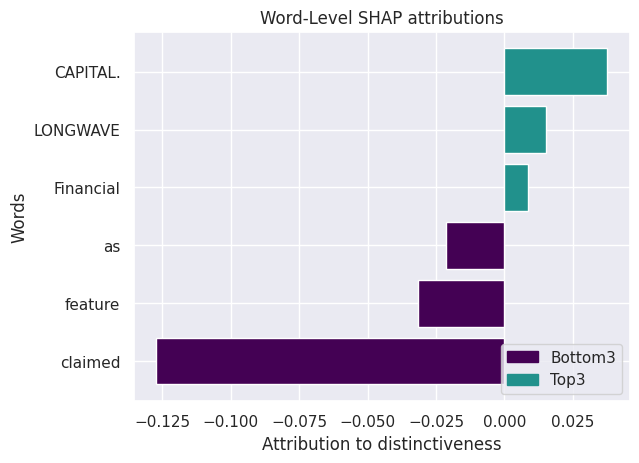





0.3468


100%|██████████| 4/4 [00:00<00:00, 167.73it/s]


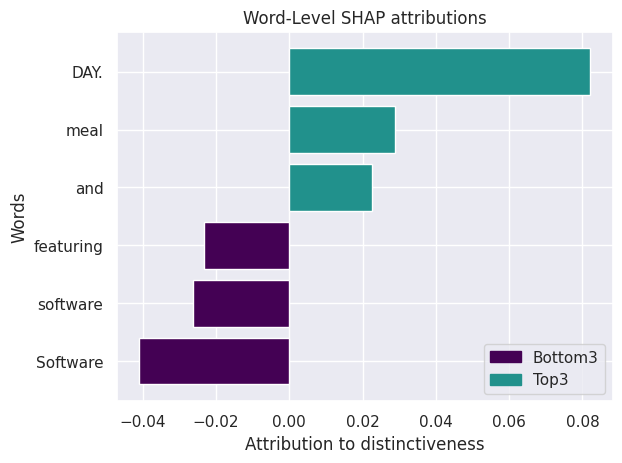





0.3593


100%|██████████| 4/4 [00:00<00:00, 158.47it/s]


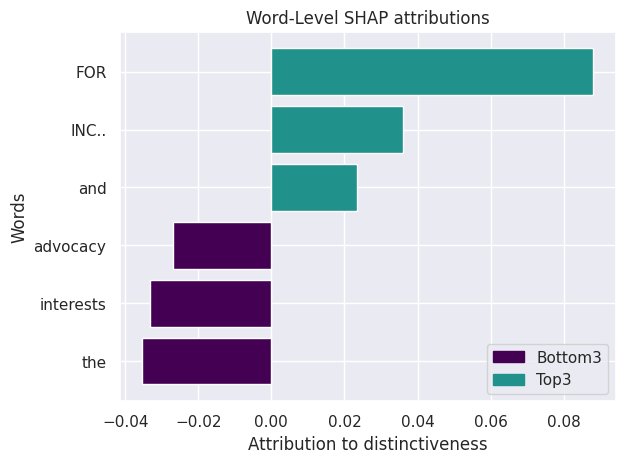





0.3691


100%|██████████| 4/4 [00:00<00:00, 155.71it/s]


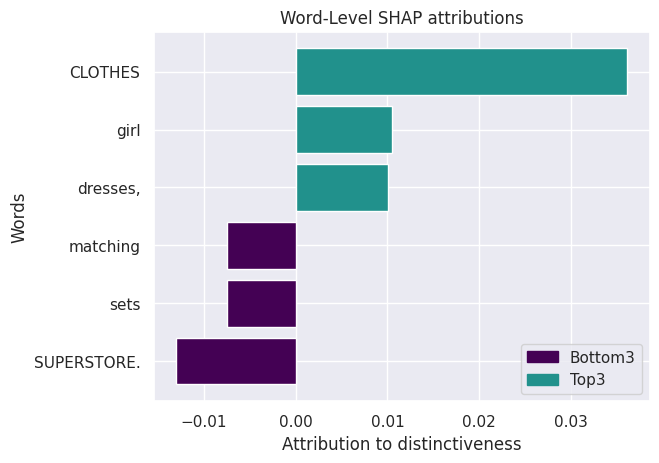





0.3794


100%|██████████| 4/4 [00:00<00:00, 158.53it/s]


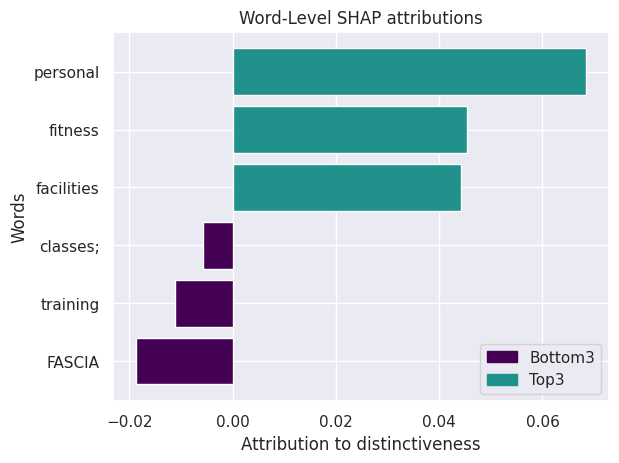





0.3816


100%|██████████| 4/4 [00:00<00:00, 154.18it/s]


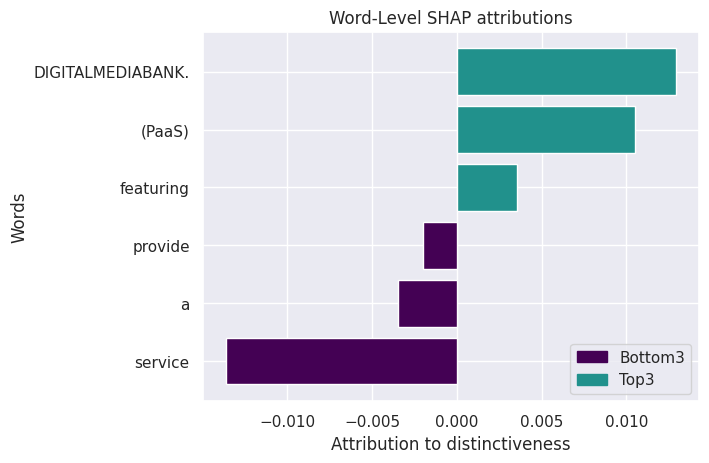





0.3819


100%|██████████| 4/4 [00:00<00:00, 139.72it/s]


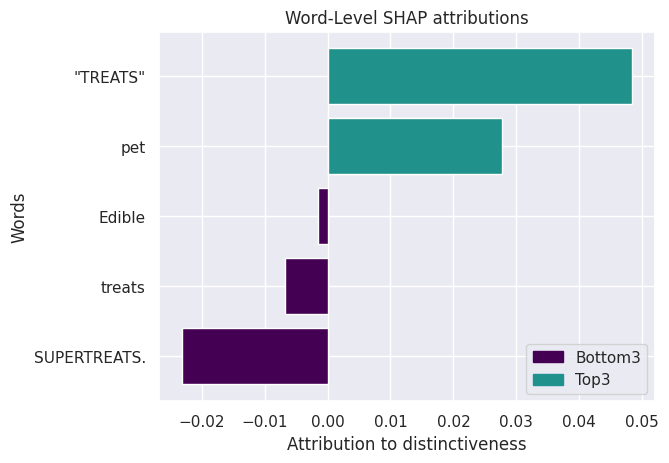

In [23]:
get_shap_plots(df, 4)

0.4069


100%|██████████| 4/4 [00:00<00:00, 160.20it/s]


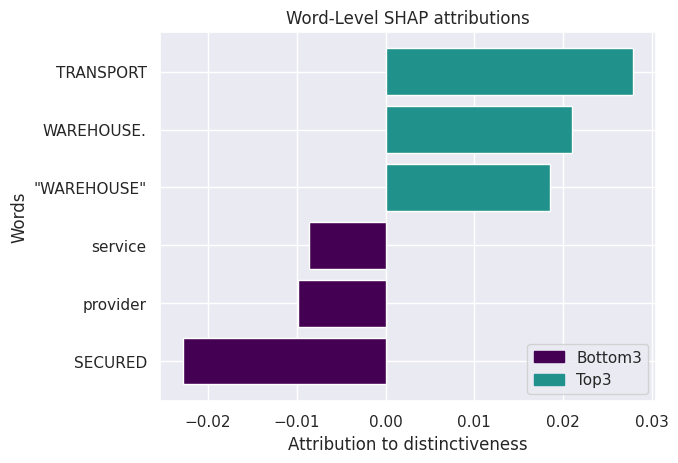





0.4088


100%|██████████| 4/4 [00:00<00:00, 141.77it/s]


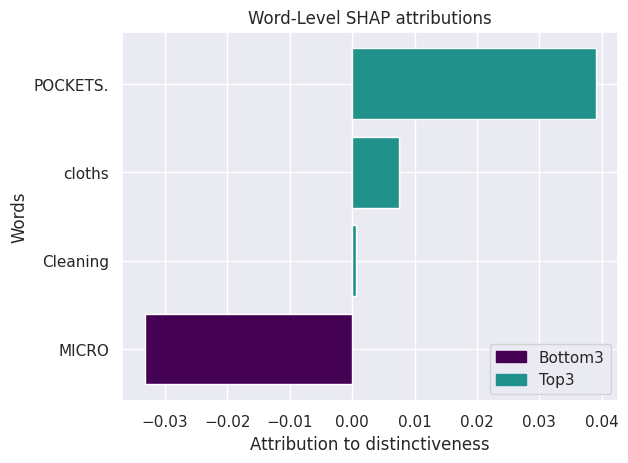





0.4111


100%|██████████| 4/4 [00:00<00:00, 171.15it/s]


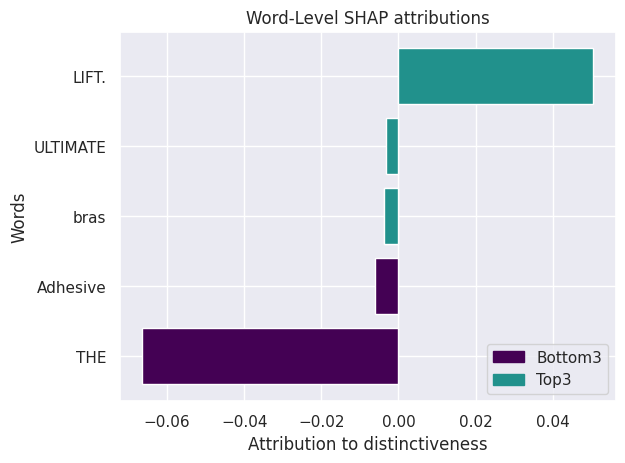





0.4272


100%|██████████| 4/4 [00:00<00:00, 167.25it/s]


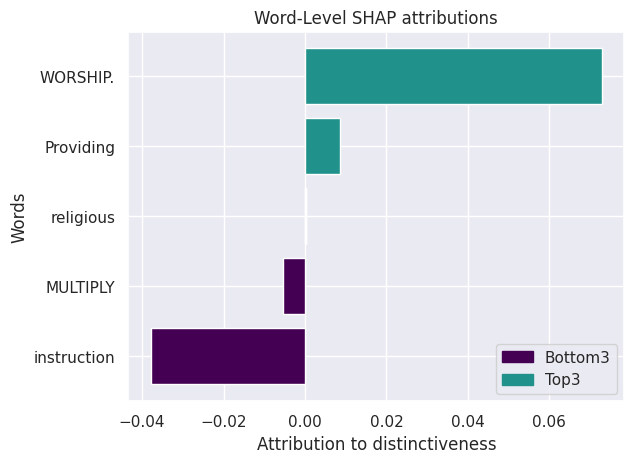





0.4284


100%|██████████| 4/4 [00:00<00:00, 135.72it/s]


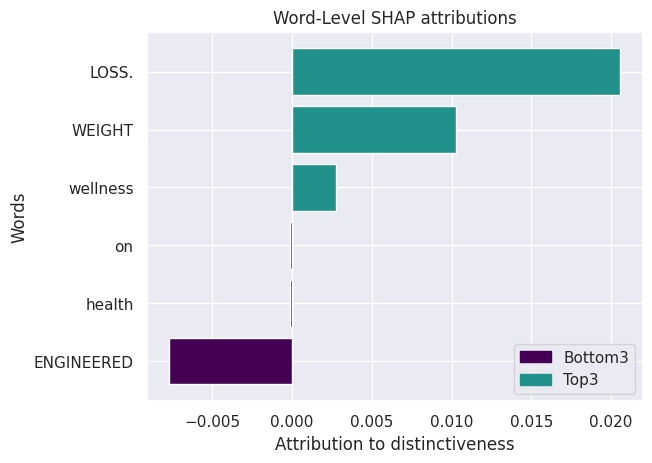





0.4528


100%|██████████| 4/4 [00:00<00:00, 155.78it/s]


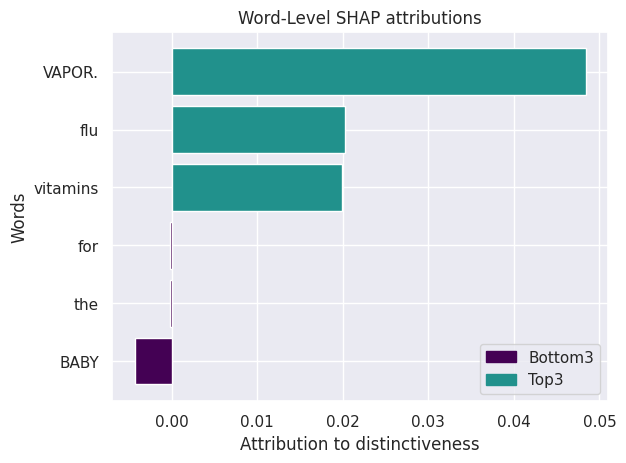





0.4759


100%|██████████| 4/4 [00:00<00:00, 153.06it/s]


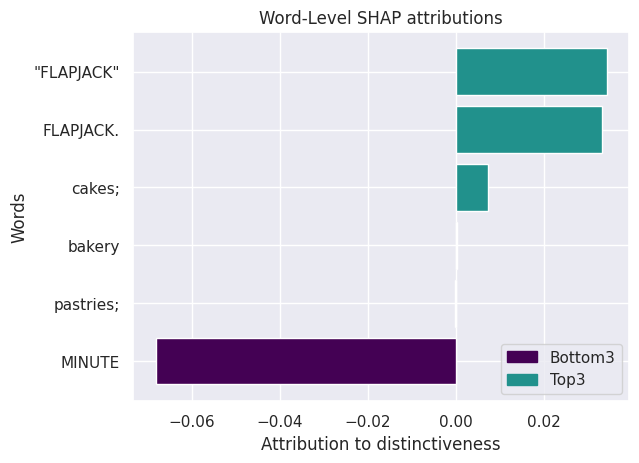





0.4858


100%|██████████| 4/4 [00:00<00:00, 162.14it/s]


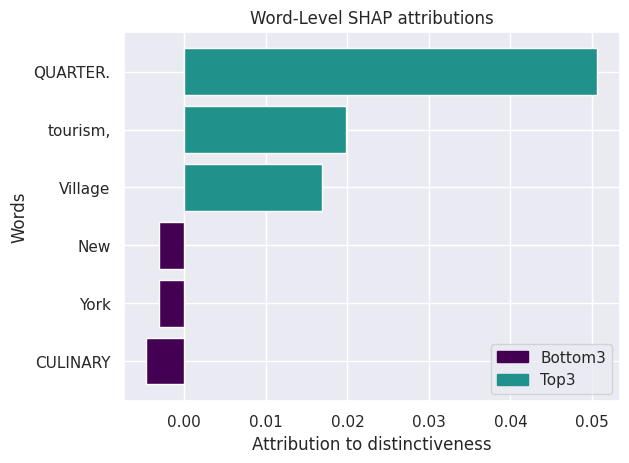





0.487


100%|██████████| 4/4 [00:00<00:00, 149.29it/s]


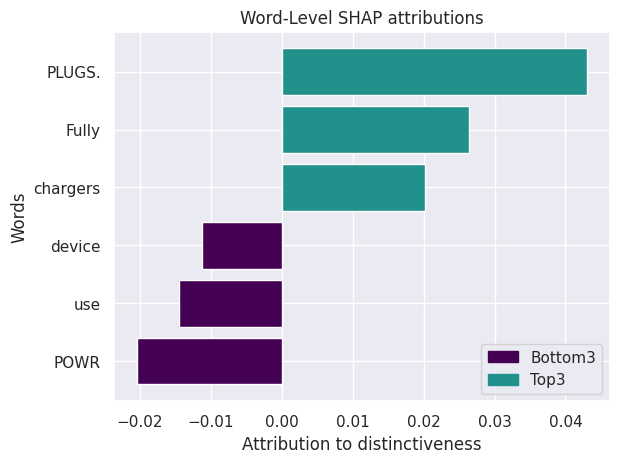





0.4942


100%|██████████| 4/4 [00:00<00:00, 157.45it/s]


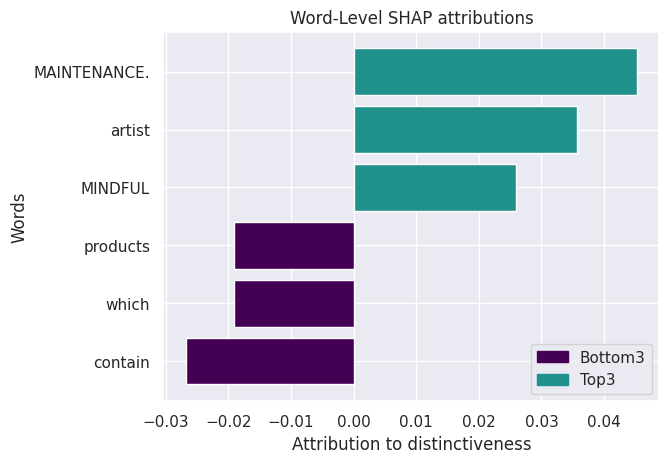

In [24]:
get_shap_plots(df, 5)

0.5276


100%|██████████| 4/4 [00:00<00:00, 168.61it/s]


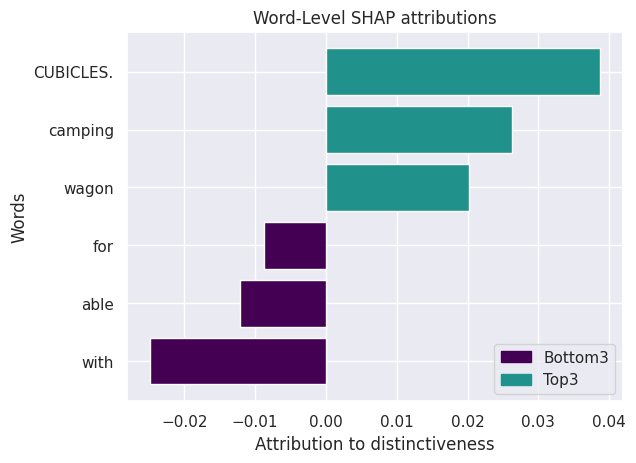





0.5298


100%|██████████| 4/4 [00:00<00:00, 166.97it/s]


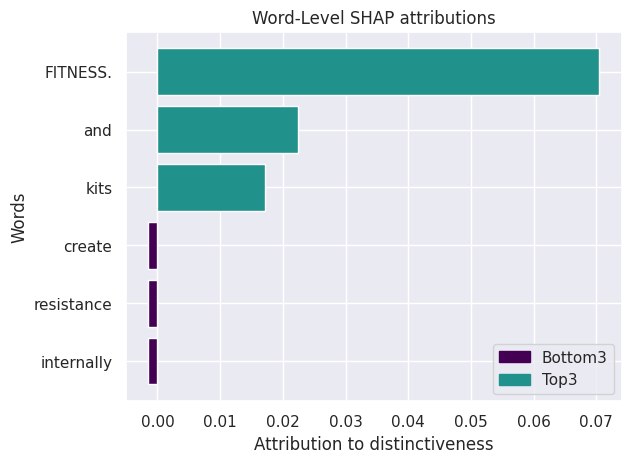





0.5397


100%|██████████| 4/4 [00:00<00:00, 165.47it/s]


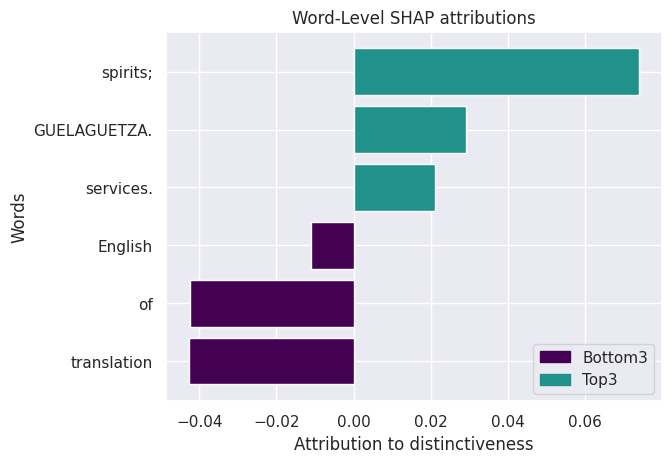





0.5464


100%|██████████| 4/4 [00:00<00:00, 156.40it/s]


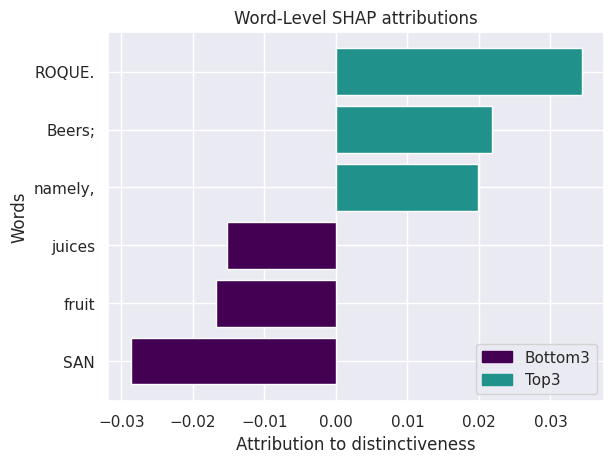





0.5484


100%|██████████| 4/4 [00:00<00:00, 164.07it/s]


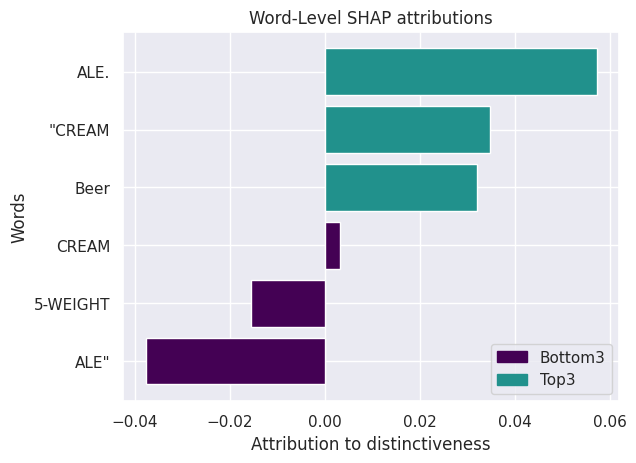





0.5682


100%|██████████| 4/4 [00:00<00:00, 168.93it/s]


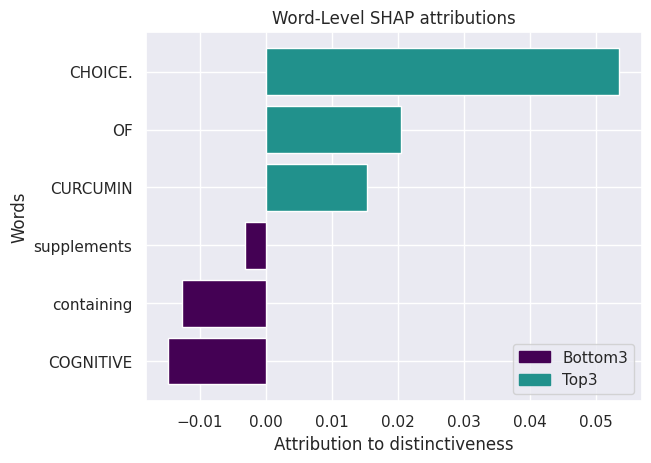





0.5795


100%|██████████| 2/2 [00:00<00:00, 165.30it/s]


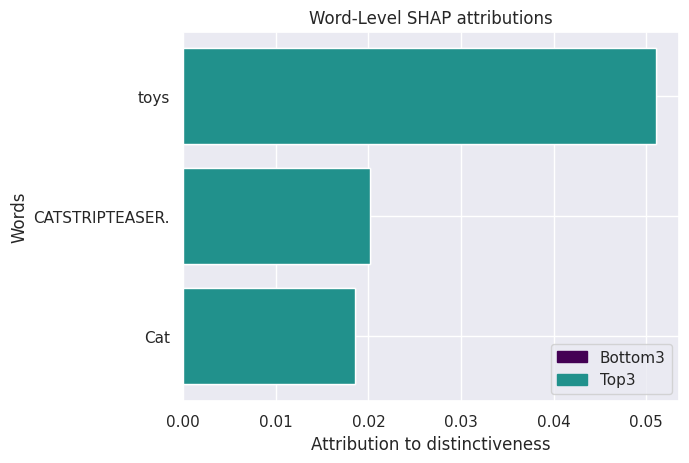





0.583


100%|██████████| 4/4 [00:00<00:00, 154.32it/s]


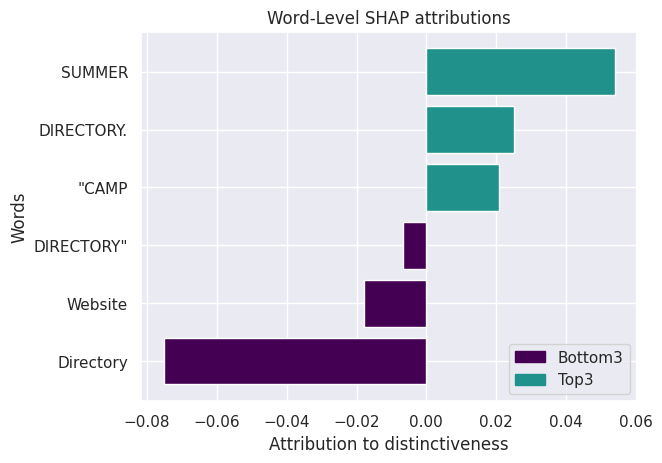





0.5917


100%|██████████| 6/6 [00:00<00:00, 137.54it/s]


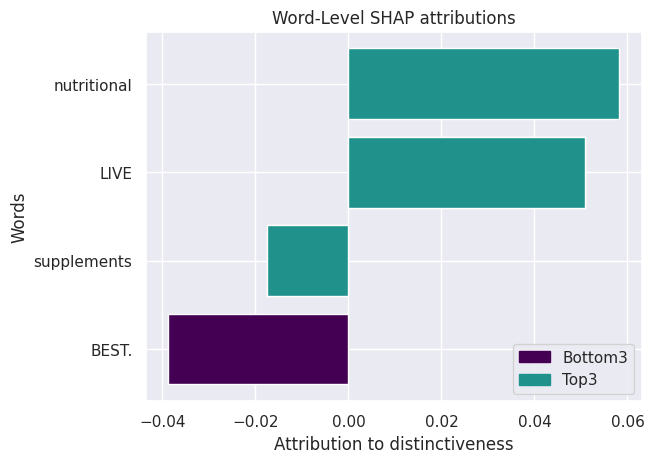





0.599


100%|██████████| 4/4 [00:00<00:00, 170.76it/s]


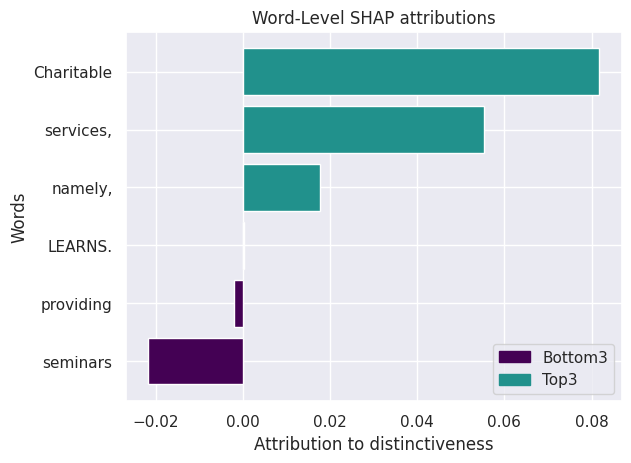

In [25]:
get_shap_plots(df, 6)

0.6051


100%|██████████| 4/4 [00:00<00:00, 172.54it/s]


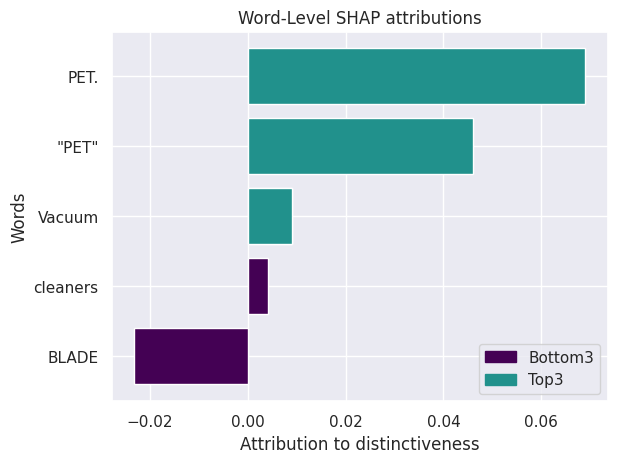





0.632


100%|██████████| 4/4 [00:00<00:00, 170.31it/s]


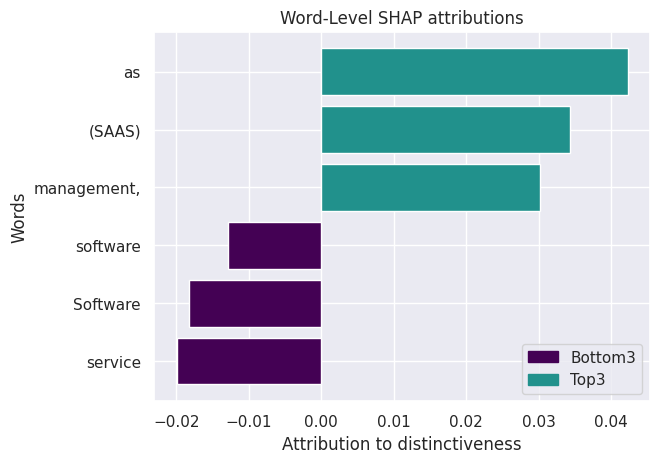





0.6331


100%|██████████| 4/4 [00:00<00:00, 169.77it/s]


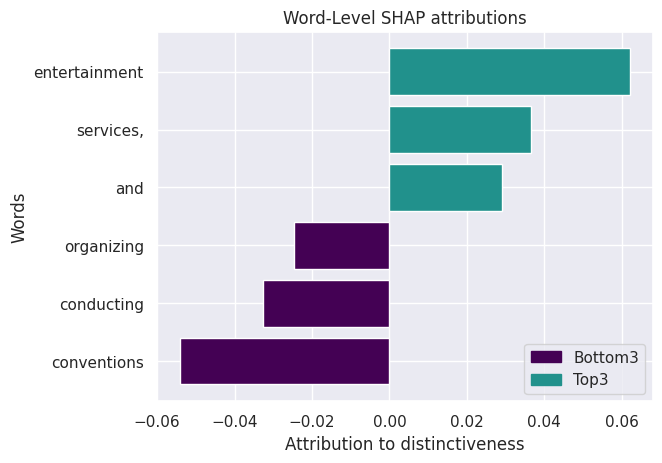





0.6416


100%|██████████| 4/4 [00:00<00:00, 151.81it/s]


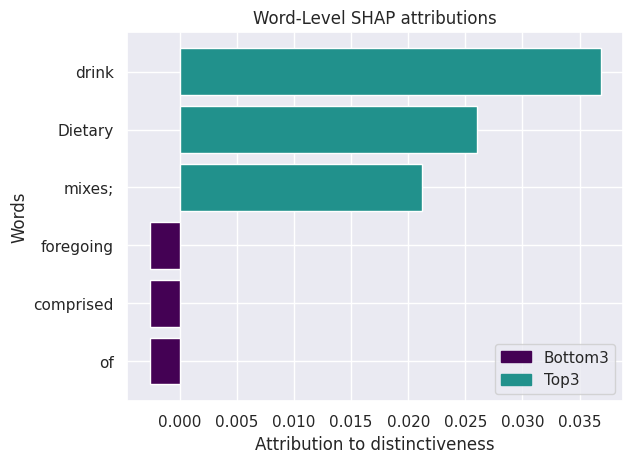





0.6436


100%|██████████| 6/6 [00:00<00:00, 167.44it/s]


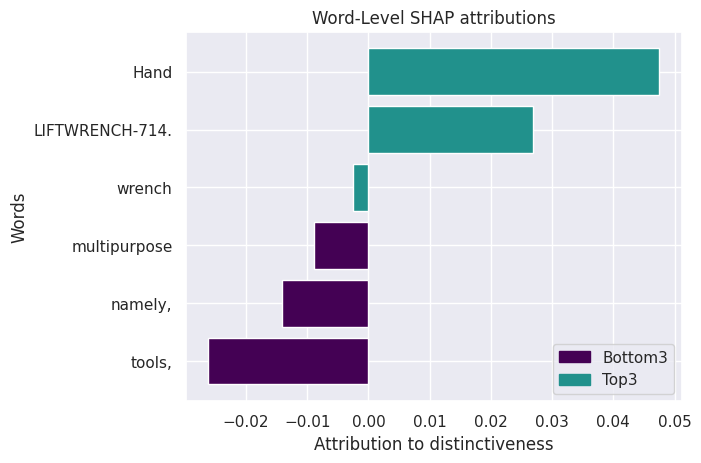





0.6539


100%|██████████| 4/4 [00:00<00:00, 117.66it/s]


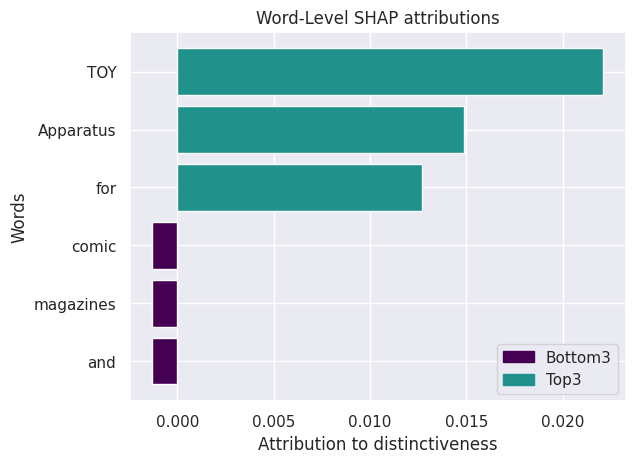





0.6606


100%|██████████| 4/4 [00:00<00:00, 163.22it/s]


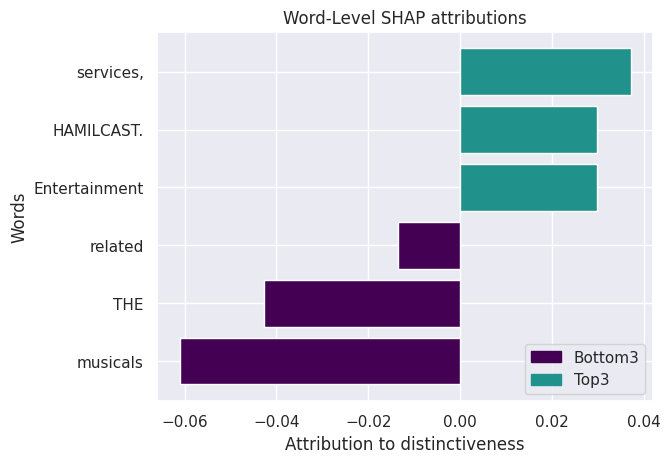





0.6613


100%|██████████| 4/4 [00:00<00:00, 147.92it/s]


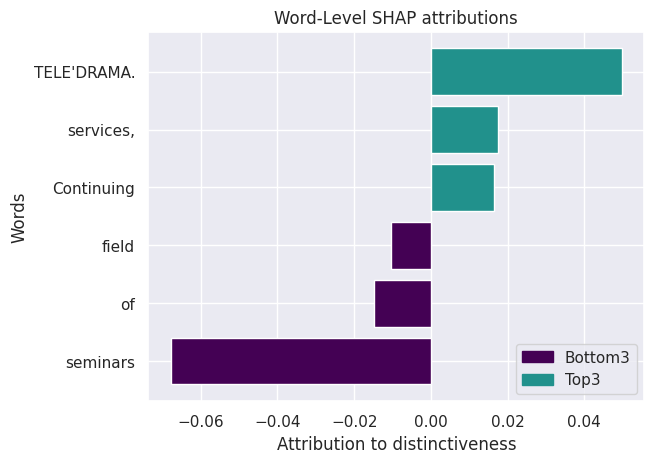





0.6787


100%|██████████| 4/4 [00:00<00:00, 160.39it/s]


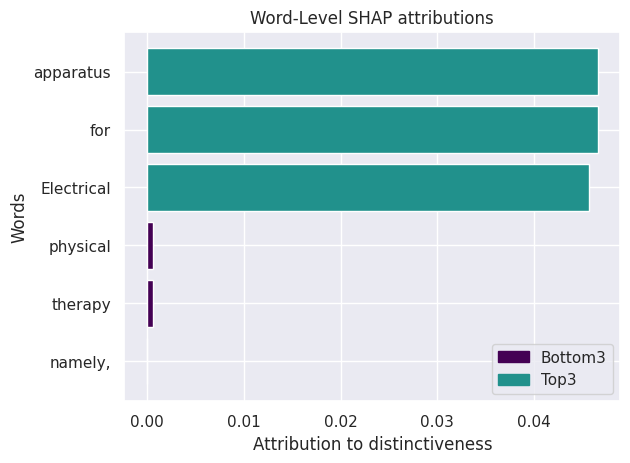





0.6938


100%|██████████| 4/4 [00:00<00:00, 168.17it/s]


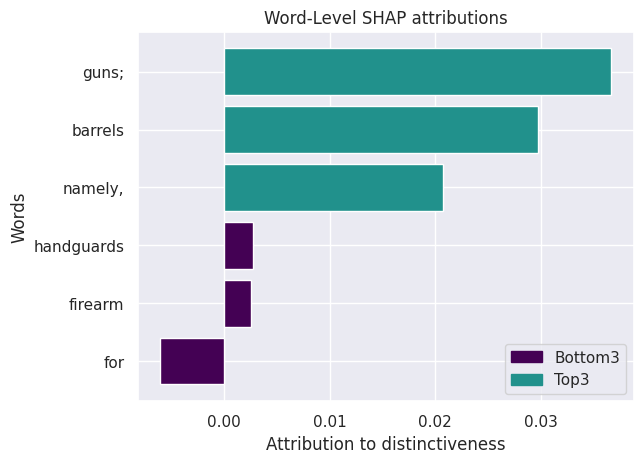

In [26]:
get_shap_plots(df, 7)

0.707


100%|██████████| 4/4 [00:00<00:00, 157.77it/s]


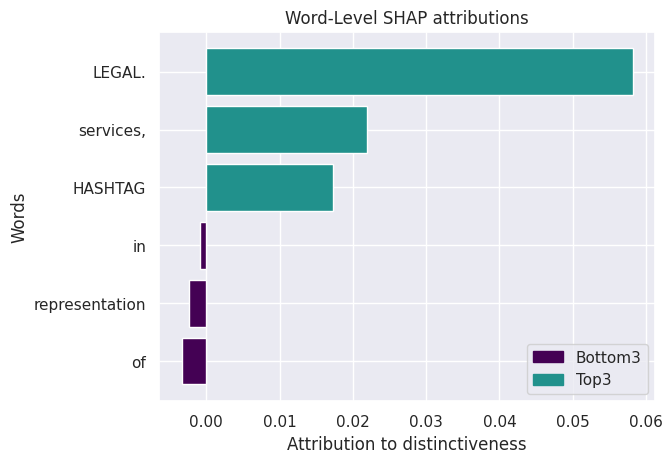





0.707


100%|██████████| 4/4 [00:00<00:00, 171.39it/s]


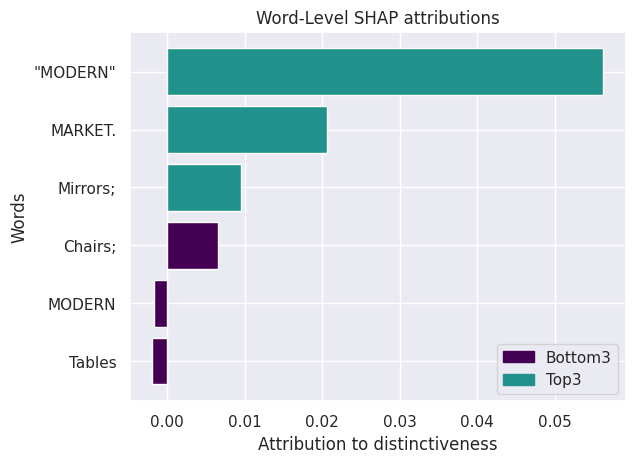





0.7194


100%|██████████| 4/4 [00:00<00:00, 135.88it/s]


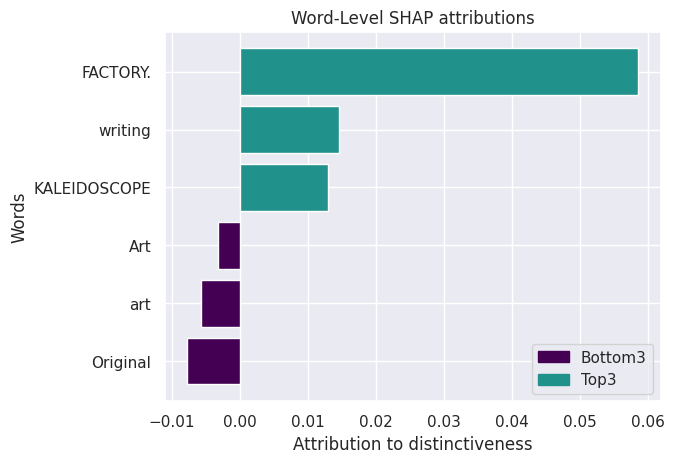





0.7219


100%|██████████| 4/4 [00:00<00:00, 165.89it/s]


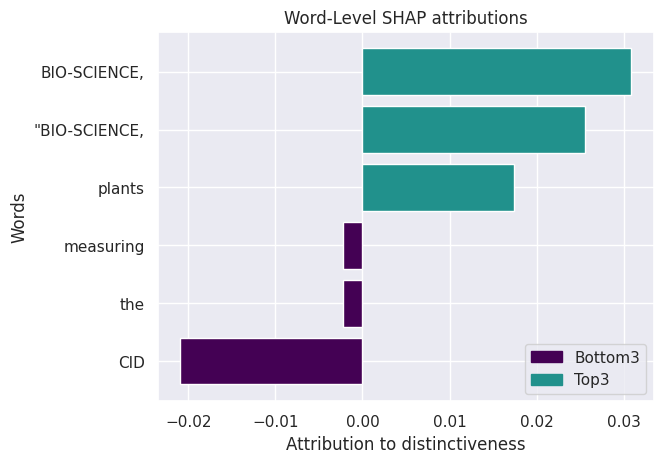





0.7333


100%|██████████| 2/2 [00:00<00:00, 155.51it/s]


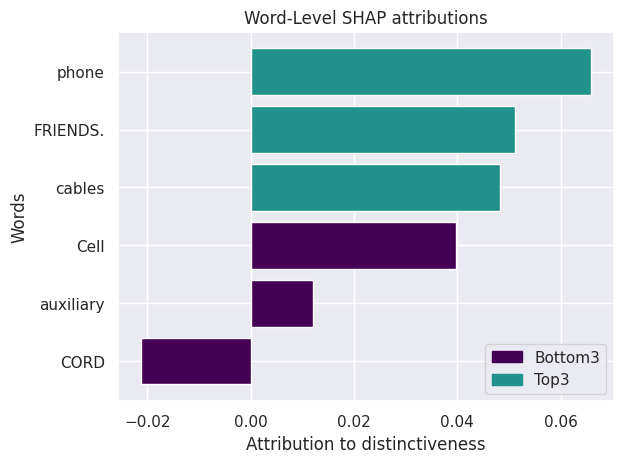





0.7632


100%|██████████| 4/4 [00:00<00:00, 168.61it/s]


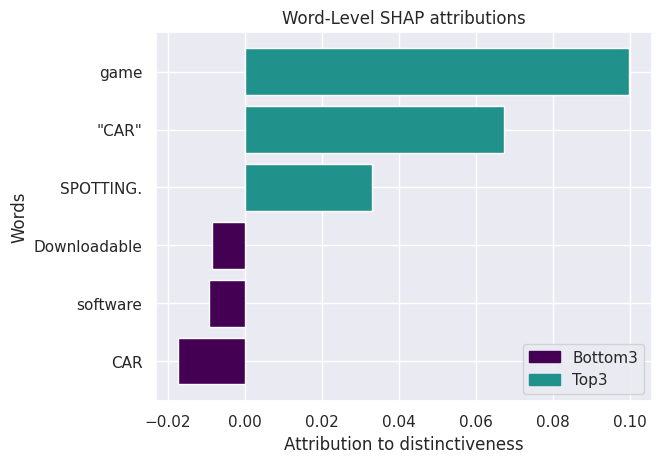





0.7763


100%|██████████| 4/4 [00:00<00:00, 162.24it/s]


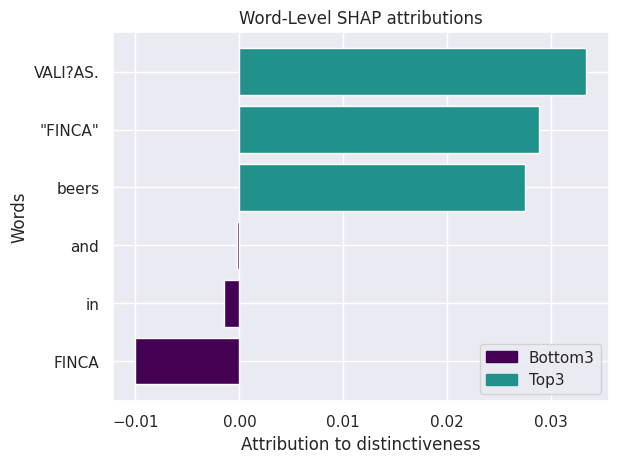





0.7862


100%|██████████| 4/4 [00:00<00:00, 170.24it/s]


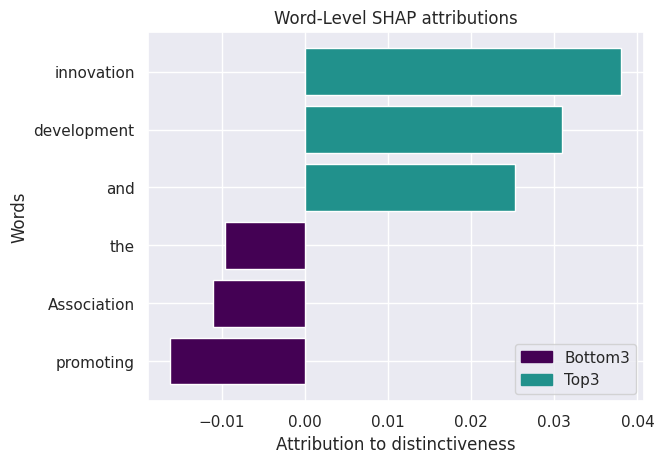





0.7938


100%|██████████| 4/4 [00:00<00:00, 157.28it/s]


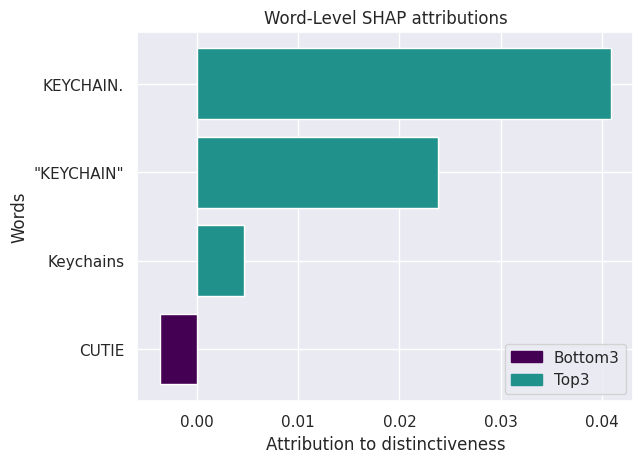





0.7938


100%|██████████| 4/4 [00:00<00:00, 166.93it/s]


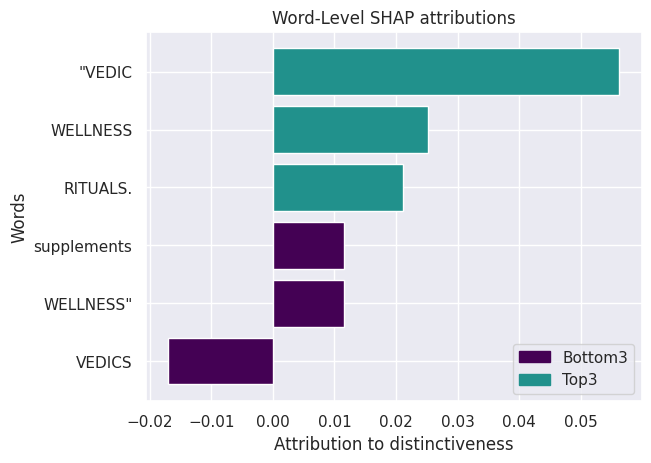

In [27]:
get_shap_plots(df, 8)

0.8147


100%|██████████| 4/4 [00:00<00:00, 155.31it/s]


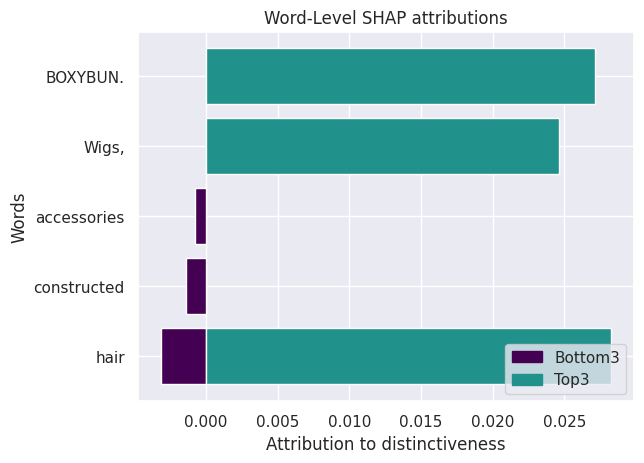





0.8165


100%|██████████| 4/4 [00:00<00:00, 166.19it/s]


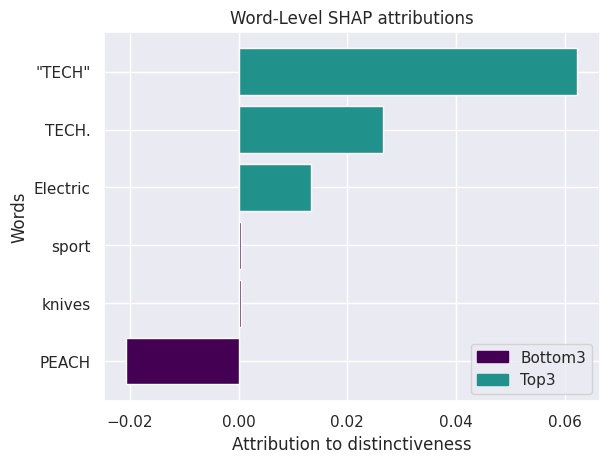





0.8313


100%|██████████| 4/4 [00:00<00:00, 163.77it/s]


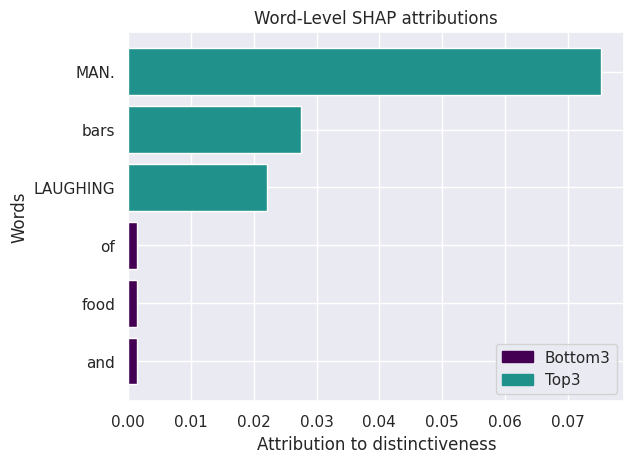





0.8345


100%|██████████| 4/4 [00:00<00:00, 164.83it/s]


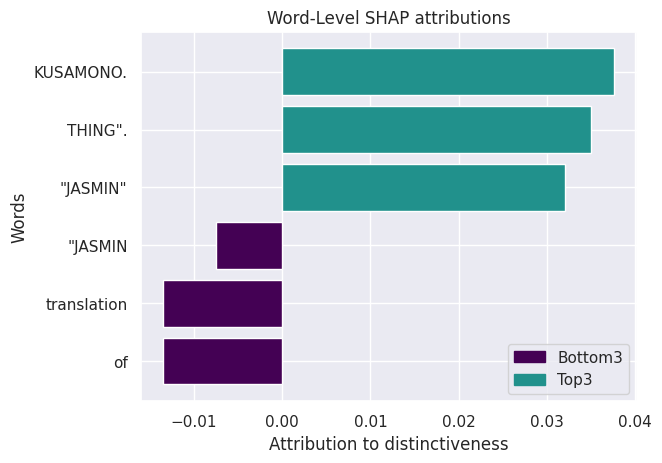





0.8383


100%|██████████| 4/4 [00:00<00:00, 151.45it/s]


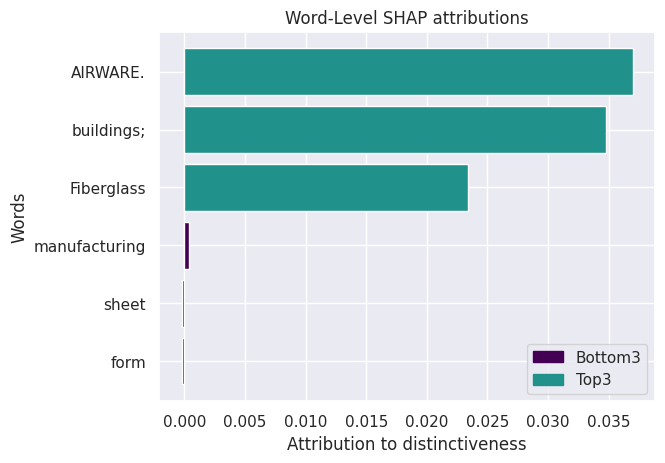





0.861


100%|██████████| 4/4 [00:00<00:00, 143.12it/s]


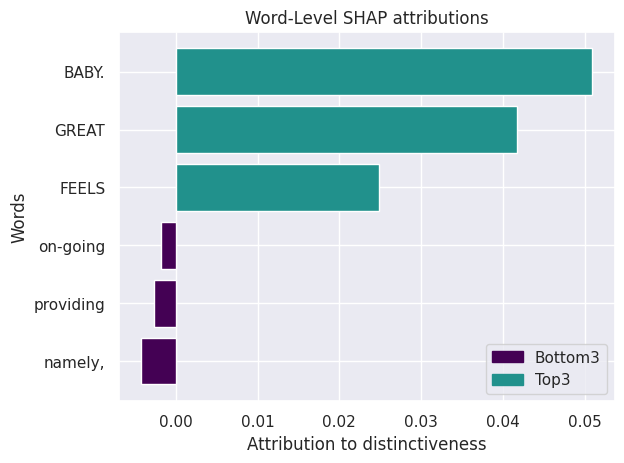





0.8794


100%|██████████| 6/6 [00:00<00:00, 172.88it/s]


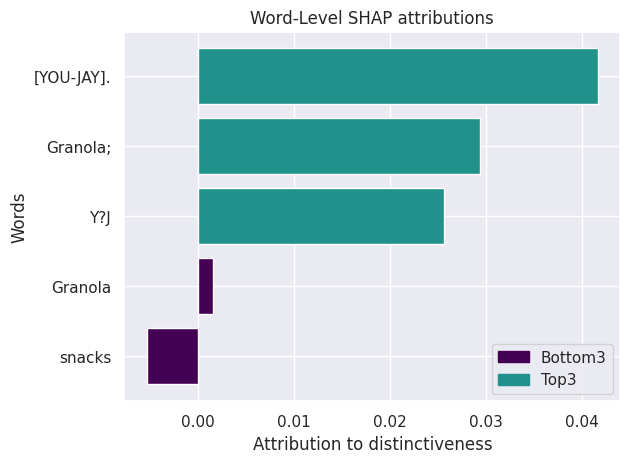





0.8808


100%|██████████| 2/2 [00:00<00:00, 130.49it/s]


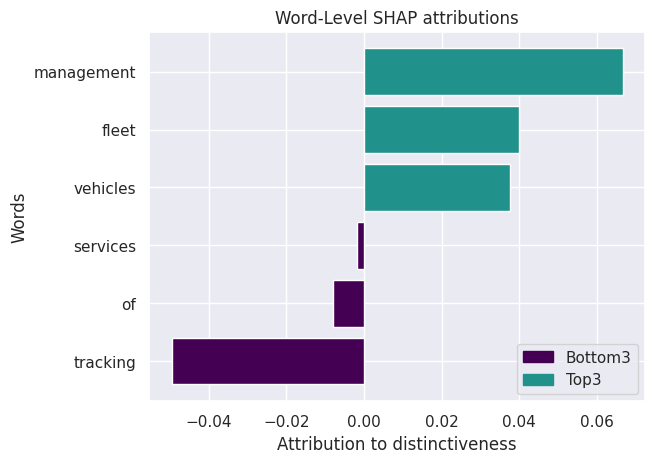





0.8837


100%|██████████| 4/4 [00:00<00:00, 158.63it/s]


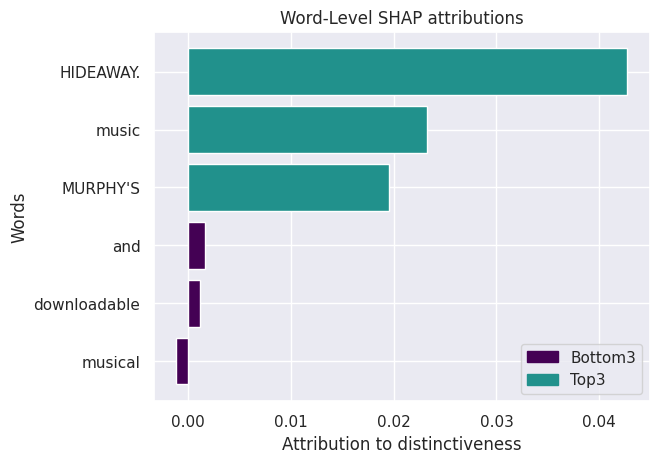





0.8986


100%|██████████| 4/4 [00:00<00:00, 168.36it/s]


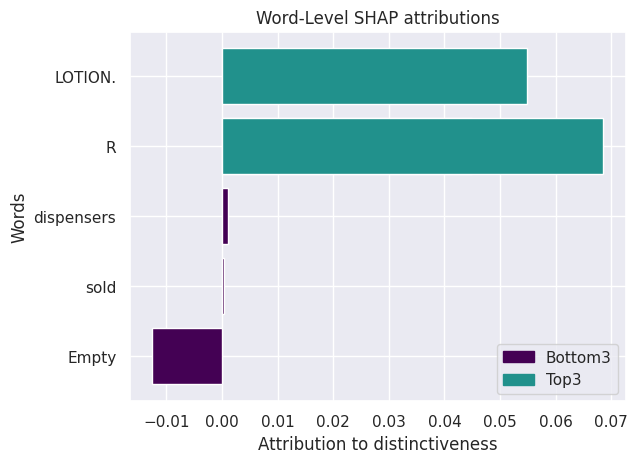

In [28]:
get_shap_plots(df, 9)

0.9205


100%|██████████| 4/4 [00:00<00:00, 161.08it/s]


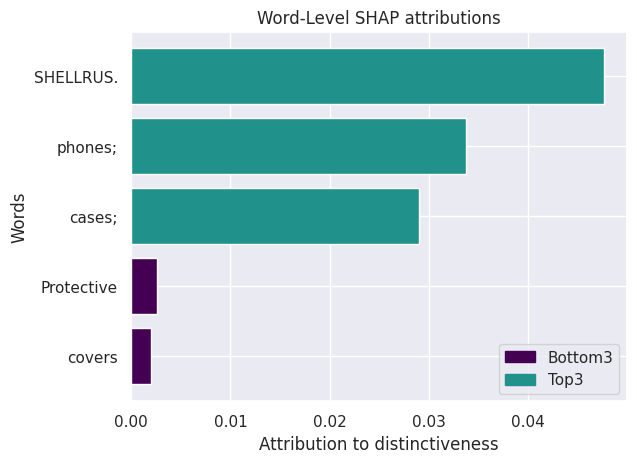





0.9212


100%|██████████| 6/6 [00:00<00:00, 175.01it/s]


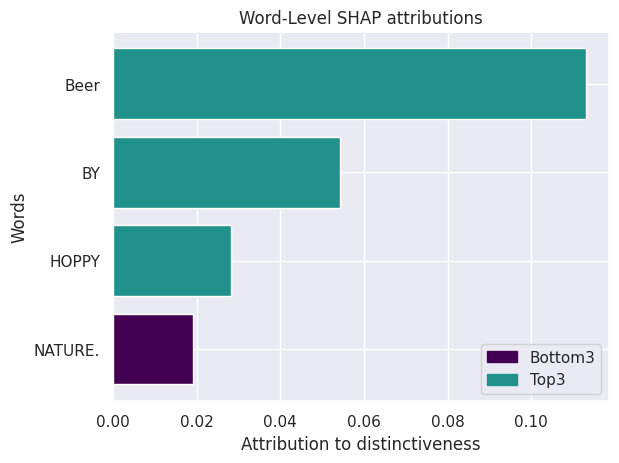





0.9251


100%|██████████| 4/4 [00:00<00:00, 155.16it/s]


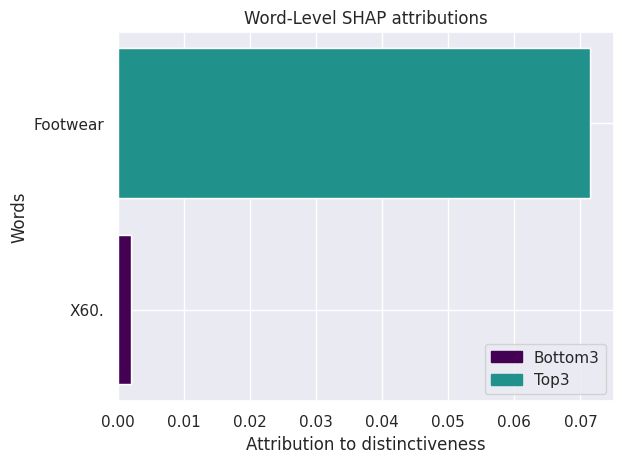





0.9275


100%|██████████| 6/6 [00:00<00:00, 158.50it/s]


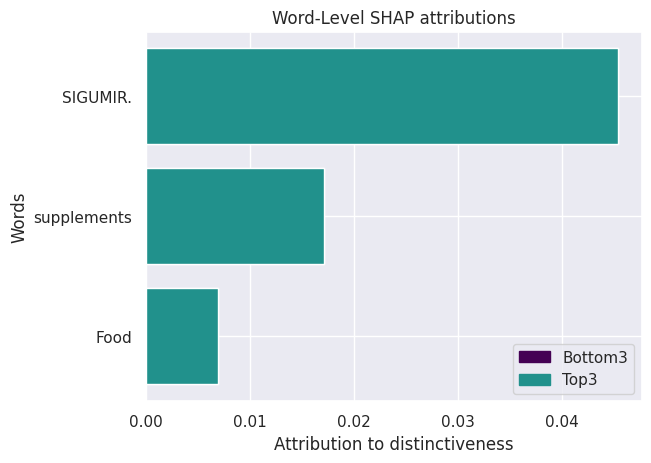





0.9435


100%|██████████| 4/4 [00:00<00:00, 173.76it/s]


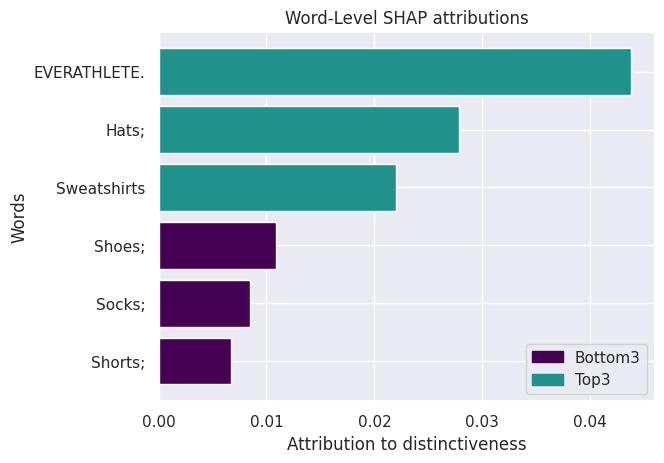





0.9501


100%|██████████| 4/4 [00:00<00:00, 156.73it/s]


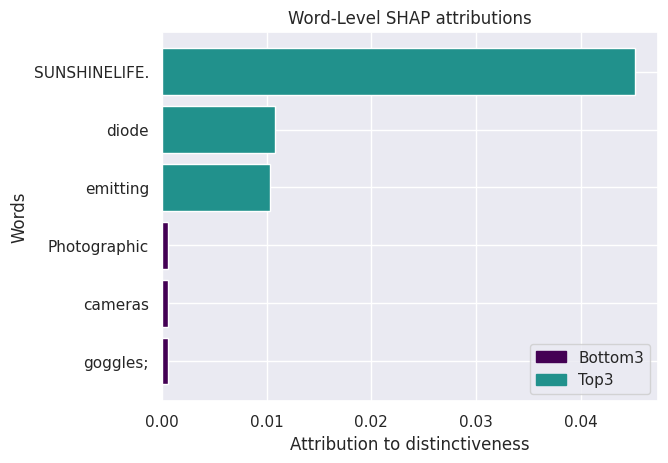





0.953


100%|██████████| 4/4 [00:00<00:00, 165.41it/s]


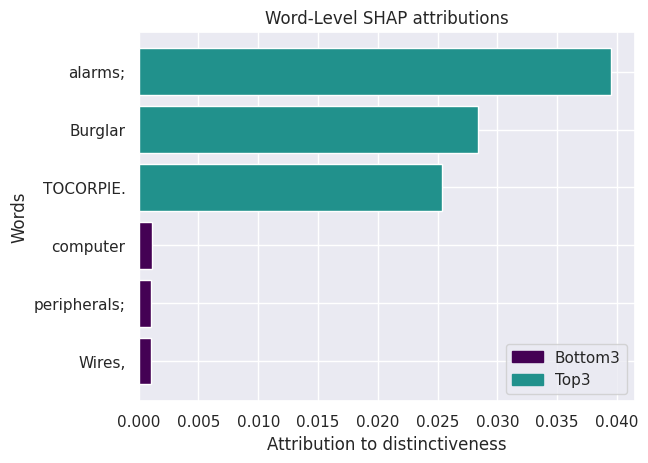





0.9532


100%|██████████| 4/4 [00:00<00:00, 153.35it/s]


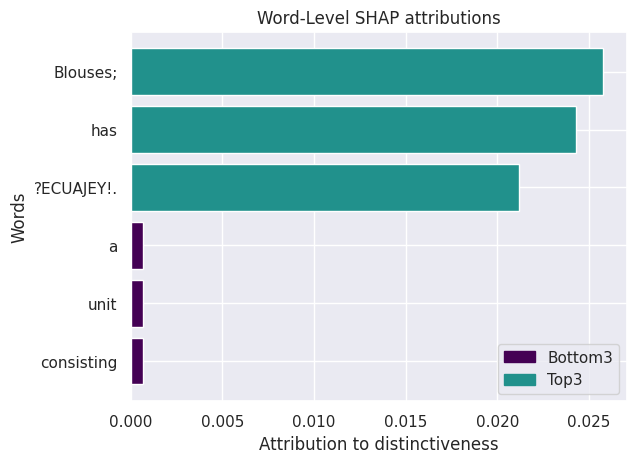





0.9542


100%|██████████| 4/4 [00:00<00:00, 172.67it/s]


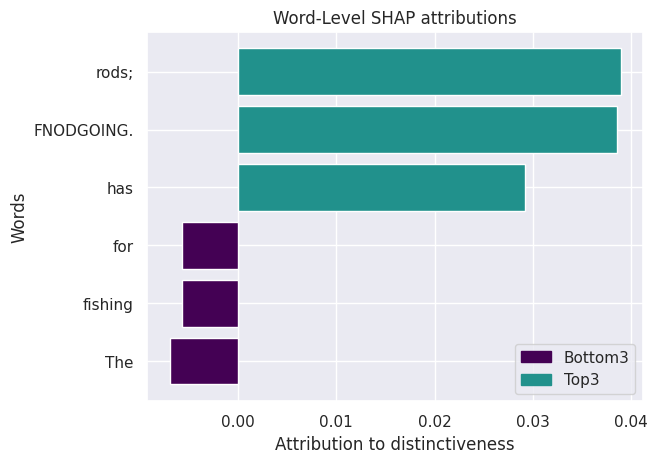





0.9547


100%|██████████| 4/4 [00:00<00:00, 166.06it/s]


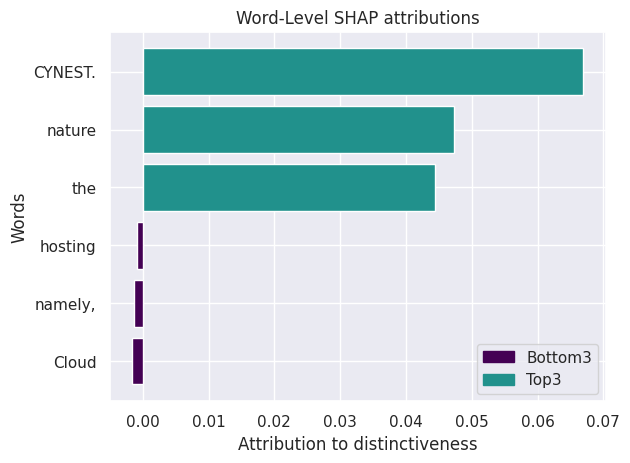





0.9602


100%|██████████| 4/4 [00:00<00:00, 162.38it/s]


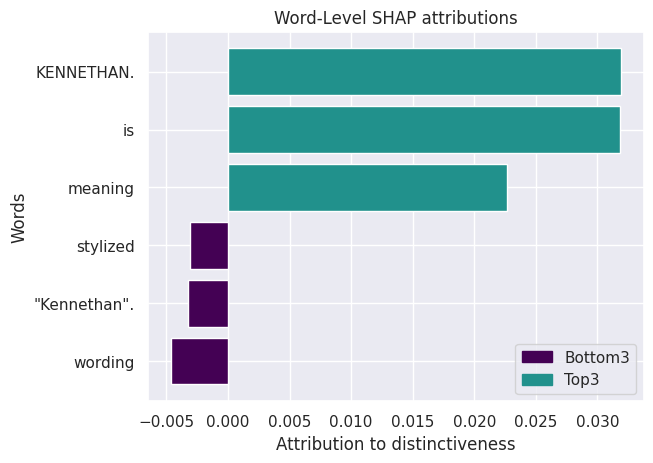





0.9673


100%|██████████| 4/4 [00:00<00:00, 132.87it/s]


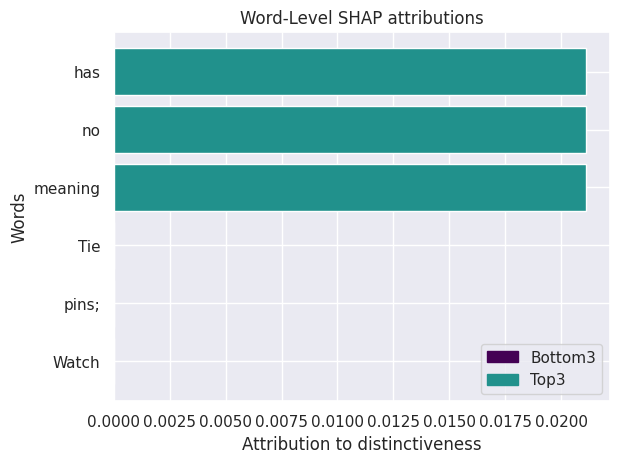





0.9673


100%|██████████| 4/4 [00:00<00:00, 157.52it/s]


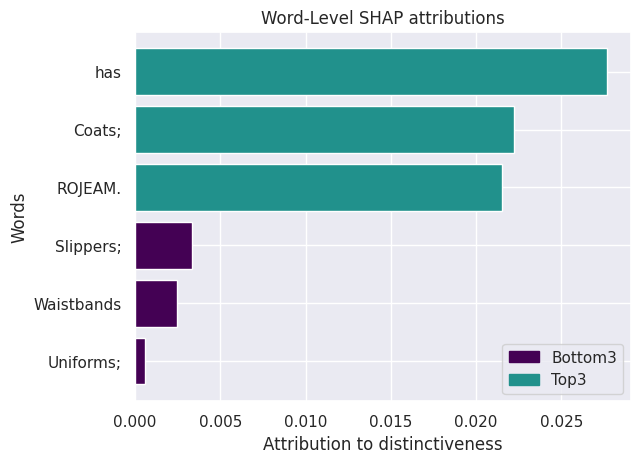





0.9677


100%|██████████| 4/4 [00:00<00:00, 155.11it/s]


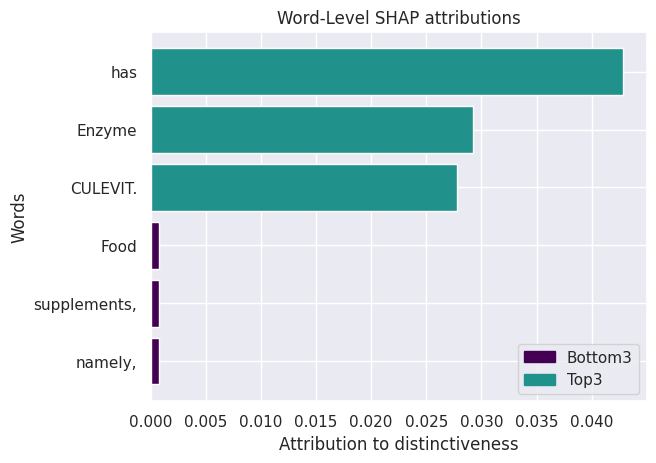





0.9694


100%|██████████| 4/4 [00:00<00:00, 127.74it/s]


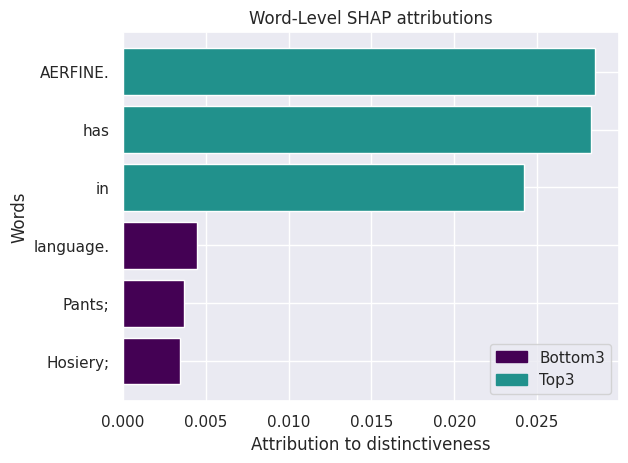





0.9723


100%|██████████| 4/4 [00:00<00:00, 161.40it/s]


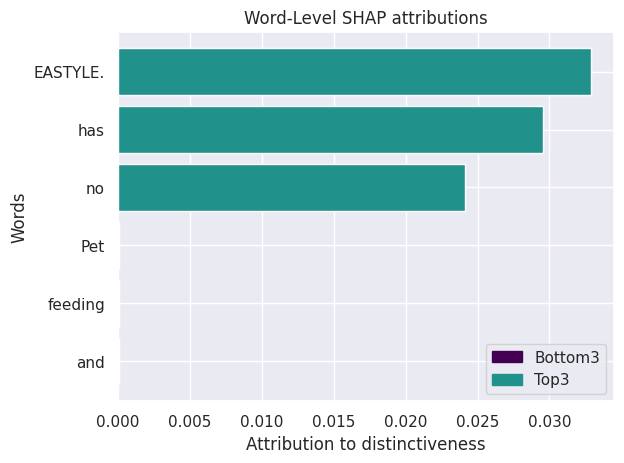





0.9728


100%|██████████| 4/4 [00:00<00:00, 156.93it/s]


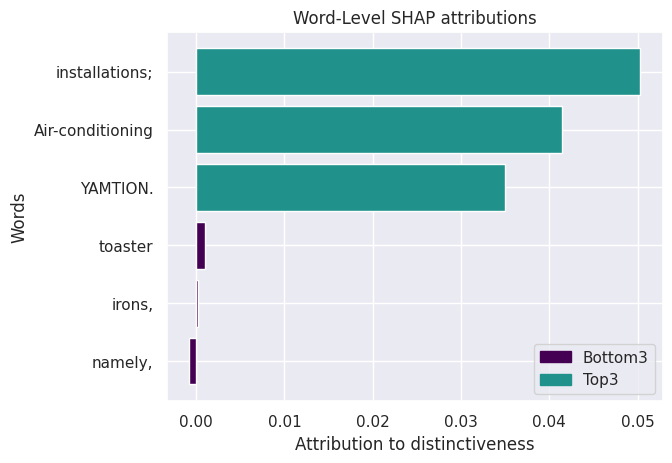





0.9759


100%|██████████| 4/4 [00:00<00:00, 135.94it/s]


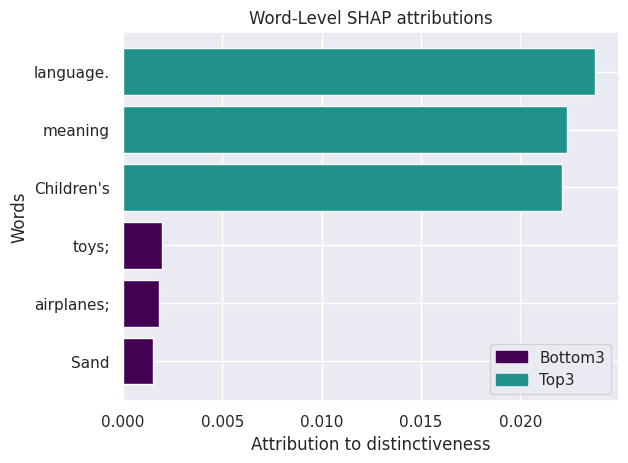





0.9761


100%|██████████| 4/4 [00:00<00:00, 127.90it/s]


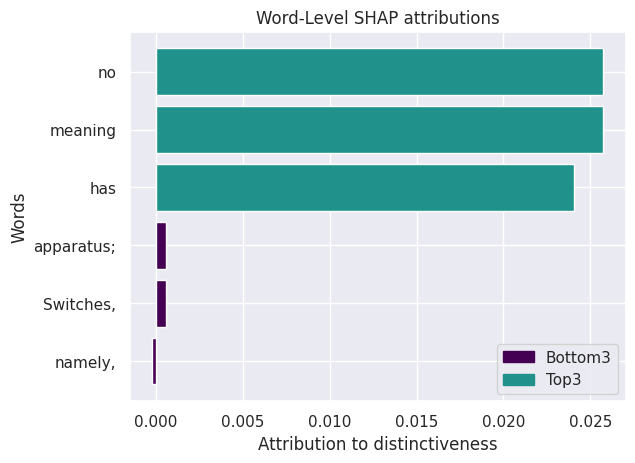





0.9786


100%|██████████| 4/4 [00:00<00:00, 151.24it/s]


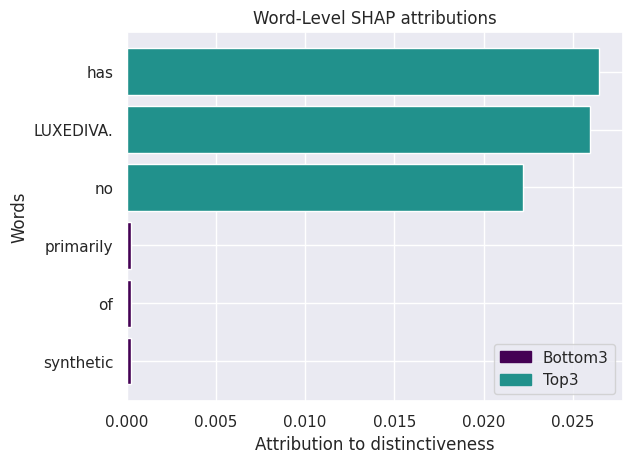





0.9803


100%|██████████| 4/4 [00:00<00:00, 158.80it/s]


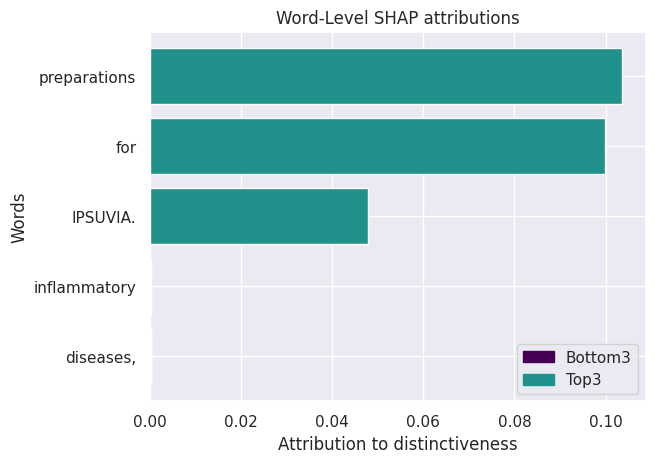





0.9803


100%|██████████| 4/4 [00:00<00:00, 156.57it/s]


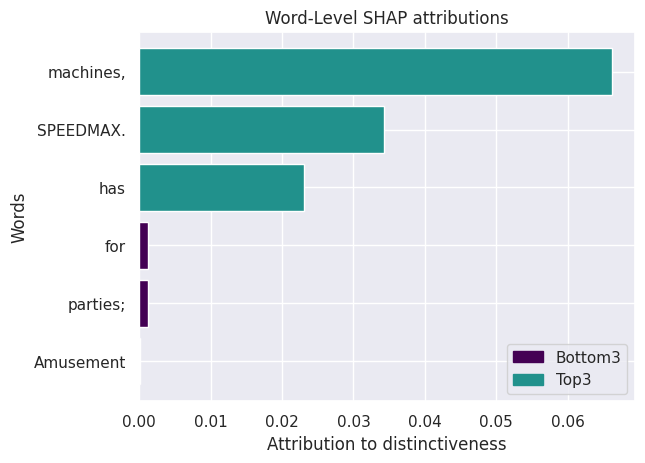





0.9808


100%|██████████| 4/4 [00:00<00:00, 158.23it/s]


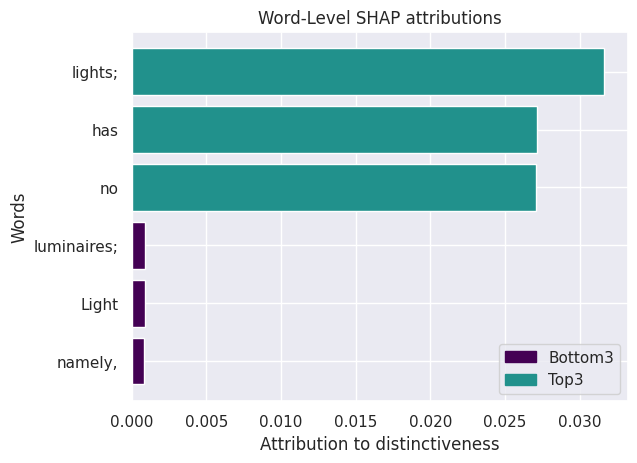





0.9814


100%|██████████| 4/4 [00:00<00:00, 135.08it/s]


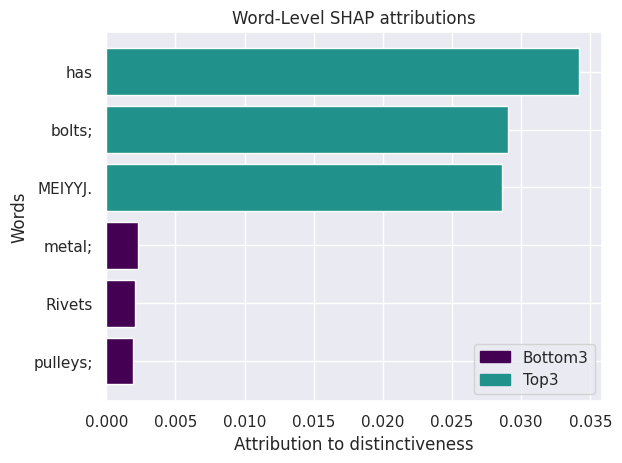





0.9816


100%|██████████| 4/4 [00:00<00:00, 159.51it/s]


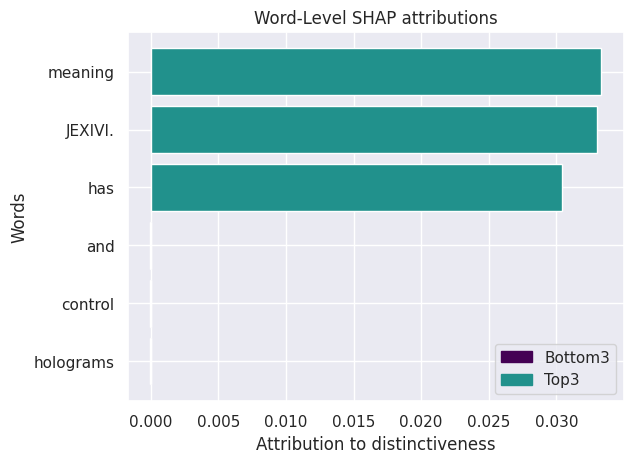

In [29]:
get_shap_plots(df, 10)